# Algorithmic Fairness, Accountability and Ethics <br> Exam Project

### Group Random
 * Constantin-Bogdan Craciun (cocr@itu.dk)
 * Gino Franco Fazzi (gifa@itu.dk)
 * Veron Hoxha (veho@itu.dk)


<br><br>
CREDITS:
 * EDA inspired from Prashant Verma - Kaggle competition (source: https://www.kaggle.com/code/prashantverma13/skin-cancer-classification-cnn-approach/notebook)
 * CNN model adapted from Manu Siddhartha - Kaggle competition (source: https://www.kaggle.com/code/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy/notebook)

## Introduction
Convolutional networks hold significant promise in the field of medical imaging, particularly in emulating dermatologists' examination criteria to identify potential cases of malignant diseases, often spanning various types of cancer. Given that initial assessments by medical professionals heavily rely on visual observations, followed by more intricate procedures such as biopsies and histopathological examinations, automating this preliminary stage could substantially expedite and streamline the diagnostic process for physicians.

The efficacy of any classification model heavily relies on the quality and quantity of the data it is trained on. Despite the exponential growth in data acquisition witnessed in recent decades, particularly fueled by the internet, the field of medical imaging encounters unique challenges and barriers to data accessibility. Issues such as data scarcity, the necessity for expert annotations, privacy concerns, and representation biases pose significant hurdles in this domain.

Within the realm of skin lesion analysis, the HAM10000 ("Human Against Machine with 10000 training images") dataset emerges as a notable resource, featuring 10,015 meticulously curated dermatoscopic images. These images serve as a foundational training set for academic machine learning pursuits and are conveniently accessible through the ISIC archive, thereby establishing a benchmark for machine learning applications and facilitating comparisons with human expert diagnoses.

Comprising seven distinct classes of skin cancer, including Melanocytic nevi, Melanoma, Benign keratosis-like lesions, Basal cell carcinoma, Actinic keratoses, Vascular lesions, and Dermatofibroma, the HAM10000 dataset offers a comprehensive representation of dermatological conditions. However, in this project, we simplify the classification task by condensing the label complexity into a binary distinction: the presence or absence of malignant cancer.

#### IMPORTS

In [1]:
# Arrays and DataFrames
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model

# OS directory managers
import os
from glob import glob

# Image
from PIL import Image
from skimage import io

# Model preprocesseing and evaluation
from sklearn.model_selection import train_test_split

# CNN Model
import keras
from keras.utils import to_categorical
from keras.src.legacy.preprocessing.image import ImageDataGenerator # THIS ONE IS DEPRECATED, BUT I DIDN'T BOTHER TO DO IT THE NEW WAY

# Misc
from datetime import datetime
import json
from utils import *
import warnings
warnings.filterwarnings("ignore")

#### FLAGS

LOAD_DATA : Indicates if raw images should be loaded and processed. If not, the notebook will try to load the Numpy array representation of it. <br>
TRAIN : Indicates if re-training of the model is performed. If not, the notebook will try to load a saved model.

In [2]:
LOAD_DATA = False
TRAIN = False

In [3]:
DATA = "../data/"
SEED = 28

np.random.seed(SEED)

# IF DATA IS NOT PRESENT
if LOAD_DATA:
    # Mapping image ids to their path
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                        for x in glob(os.path.join(DATA+"HAM10000/images/", '*.jpg'))}

# Mapping dictionaries for variables, matching description from research paper
mapping = {
    "lesion_type": {
    'nv': 'Melanocytic nevi', # Same lesion type, different coding in HAM10000
    'nev': 'Nevus', # Same lesion type, different coding in PAD-UFES-20
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses', # Same lesion type, different coding in HAM10000
    'ack': 'Actinic keratoses', # Same lesion type, different coding in PAD-UFES-20
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma',
    'scc': 'Squamous Cell Carcinoma',
    'sek': 'Seborrheic Keratosis',
    },
    "diagnosis": {
        "histo": "Histopathology",
        "follow_up": "Follow-up",
        "consensus": "Expert consensus",
        "confocal": "In-vivo confocal microscopy"
    },
    # Binary Cancer (1) vs Non-Cancer
    "cancer": {
        0: ["Melanocytic nevi", "Nevus", "Actinic keratoses", "Benign keratosis-like lesions", "Vascular lesions", "Dermatofibroma", "Seborrheic Keratosis"],
        1: ["Melanoma", "Basal cell carcinoma", "Squamous Cell Carcinoma"]
    },
    # Fitspatrick to binary
    "fitspatrick": {
        "light_skin": [1.,2.,3.],
        "dark_skin": [4.,5.,6.]
    }
}

## Data

NOTE: The data used in this project comes from two sources:
 - HAM10000 dataset, used for training our classifier (source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T). This dataset contains 10,015 image (600x450 px), for a total of 2.57 GB (uncompressed).
 - PAD-UFES-20 dataset, used for testing our classifier (source: https://data.mendeley.com/datasets/zr7vgbcyr2/1). This dataset contains 2,298 images (different resolutions), for a total of 3.35 GB (uncompressed)

For simplicity, we have saved the trained model used for inference. <br>
For complete reproducibility, you can download the images (free access) and put them in the following location "./data/HAM10000/images" and ".data/PAD-UFES-20/images". The, turn the LOAD_DATA flag to True.

The associated metadata for the datasets are included in this repository.

### Loading and mappings

Datasets are composed by images of skin lesions and tables with metadata (e.g., age and gender of the patient, etc.)
For simplicity, we load the metadata and append to each lesion id the path to the image.
We map the codes from the variables to human readable text, to simplify understanding. Finally, we also map the cell_type to a numerical code from 0 to 6.

In [4]:
# Load HAM10000 metadata
metadata = pd.read_csv(DATA + 'HAM10000/metadata.csv')

# Creating mapped columns for better readability
if LOAD_DATA:
    metadata['path'] = metadata['image_id'].map(imageid_path_dict.get)
metadata['dx'] = metadata['dx'].map(mapping["lesion_type"]) 
metadata['dx_type'] = metadata['dx_type'].map(mapping["diagnosis"])
metadata["sex"] = metadata.sex.str.capitalize()
metadata["localization"] = metadata.localization.str.capitalize()
metadata['dx_idx'] = pd.Categorical(metadata['dx']).codes ## THIS WE DON'T NEED ANYMORE

metadata.head()

lesion_id      image_id                             dx         dx_type  \
0  HAM_0000118  ISIC_0027419  Benign keratosis-like lesions  Histopathology   
1  HAM_0000118  ISIC_0025030  Benign keratosis-like lesions  Histopathology   
2  HAM_0002730  ISIC_0026769  Benign keratosis-like lesions  Histopathology   
3  HAM_0002730  ISIC_0025661  Benign keratosis-like lesions  Histopathology   
4  HAM_0001466  ISIC_0031633  Benign keratosis-like lesions  Histopathology   

    age   sex localization  dx_idx  
0  80.0  Male        Scalp       2  
1  80.0  Male        Scalp       2  
2  80.0  Male        Scalp       2  
3  80.0  Male        Scalp       2  
4  75.0  Male          Ear       2

### Data wrangling

First, we check for data types and null values.

In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dx_idx        10015 non-null  int8   
dtypes: float64(1), int8(1), object(6)
memory usage: 557.6+ KB


It seems there are some null values for the age feature. We can replace them by the mean.

In [6]:
metadata['age'] = metadata['age'].fillna((metadata['age'].mean()))
metadata.age = metadata.age.astype(int) # Now we have no nulls, so we can simplify the datatype to int
metadata.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dx_idx          0
dtype: int64

## EDA

We will perform a basic Exploratory Data Analysis on the data and its variables.

### Lesion types

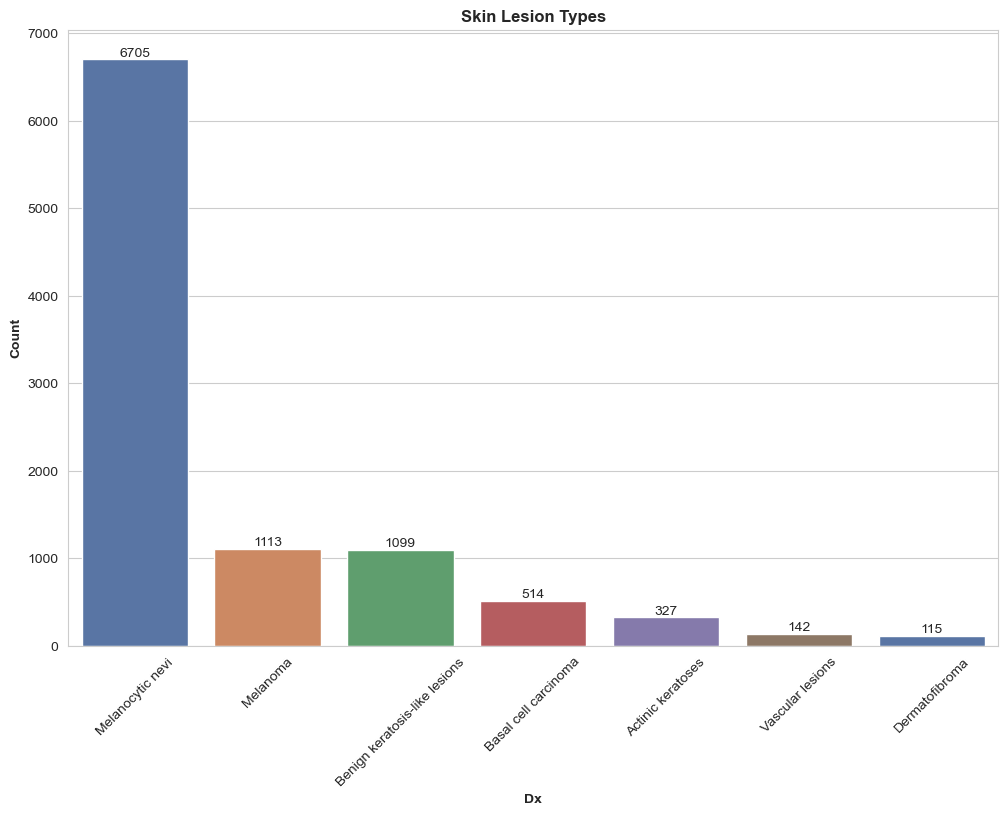

In [7]:
EDA_plots(data = metadata, variable = "dx", title = "Skin Lesion Types")

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

### Diagnosis basis

Here, we look at the distribution of the diagnosis basis. This indicates how the ground truth was obtained (for more detail information please check the data source information).

The diagnosis (ground truth) is obtained by either:
**1. Histopathology(Histo):**  Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists. <br>
**2. Confocal:** Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after  manual histogram changes.<br>
**3. Follow-up:** If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists  accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions. <br>
**4. Consensus:** For typical benign cases without histopathology or followup biologists  provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

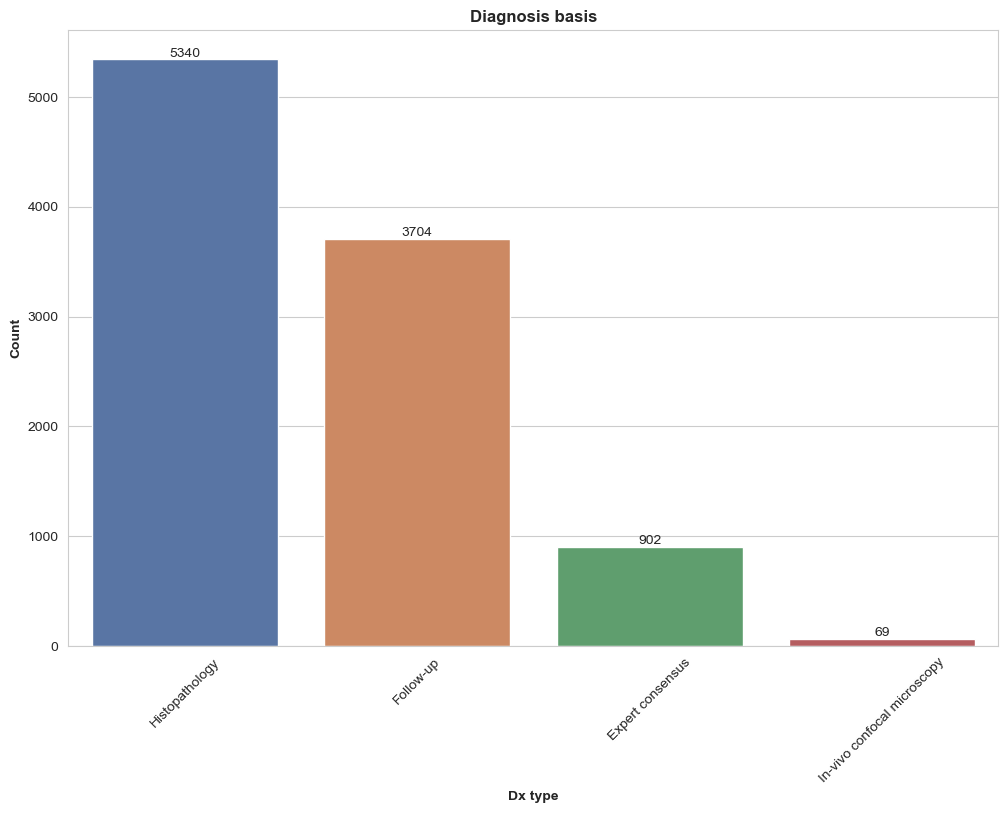

In [8]:
EDA_plots(data=metadata, variable="dx_type", title="Diagnosis basis")

We can also look if diagnosis vary across genders.

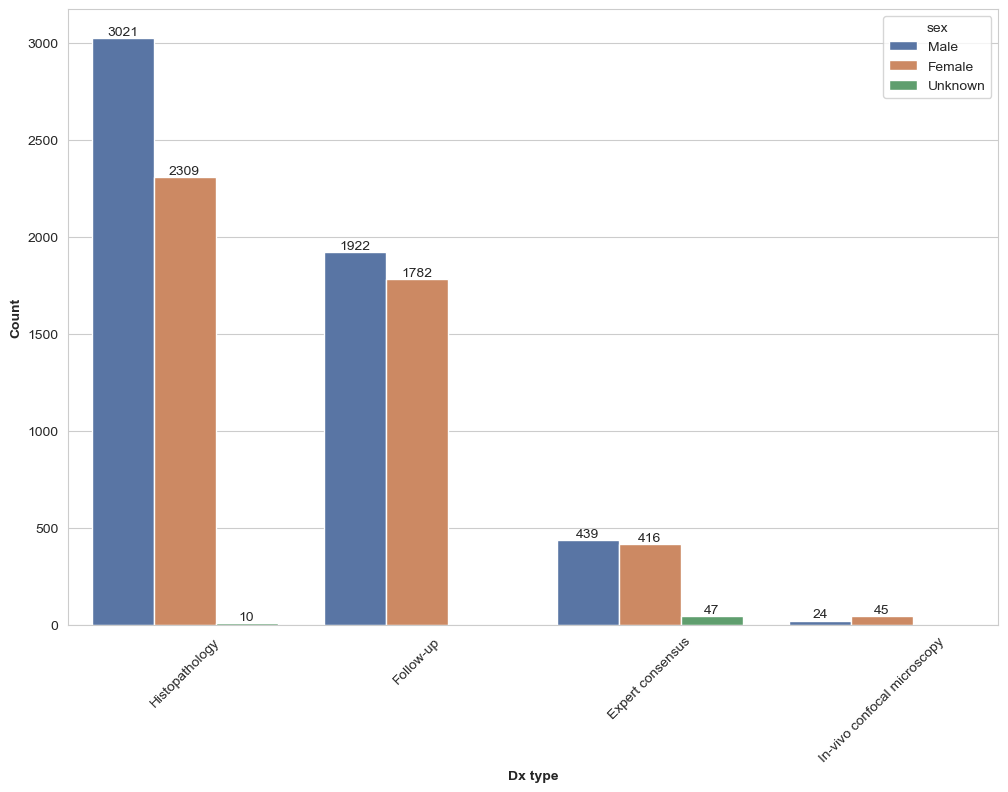

In [9]:
EDA_plots(data=metadata, variable="dx_type", hue="sex")

### Lesion localization

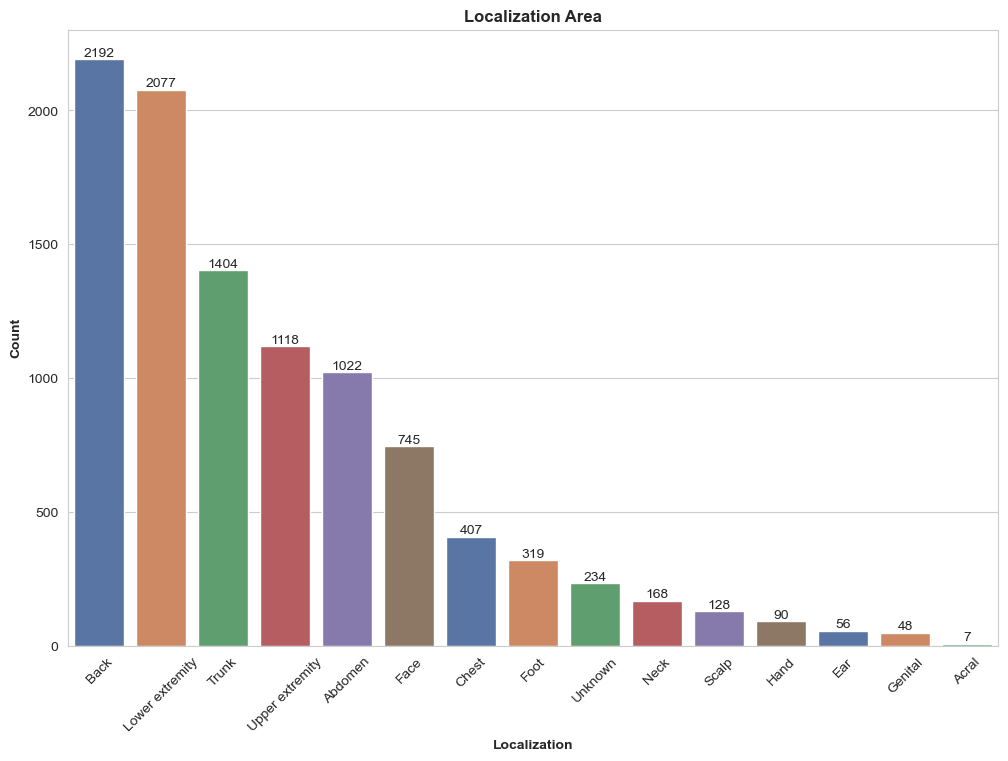

In [10]:
EDA_plots(data=metadata, variable="localization", title="Localization Area")

Data shows that the back and lower extremities are the most frequent place for skin lesions.

Again, we could split this histogram by gender to investigate for differences.

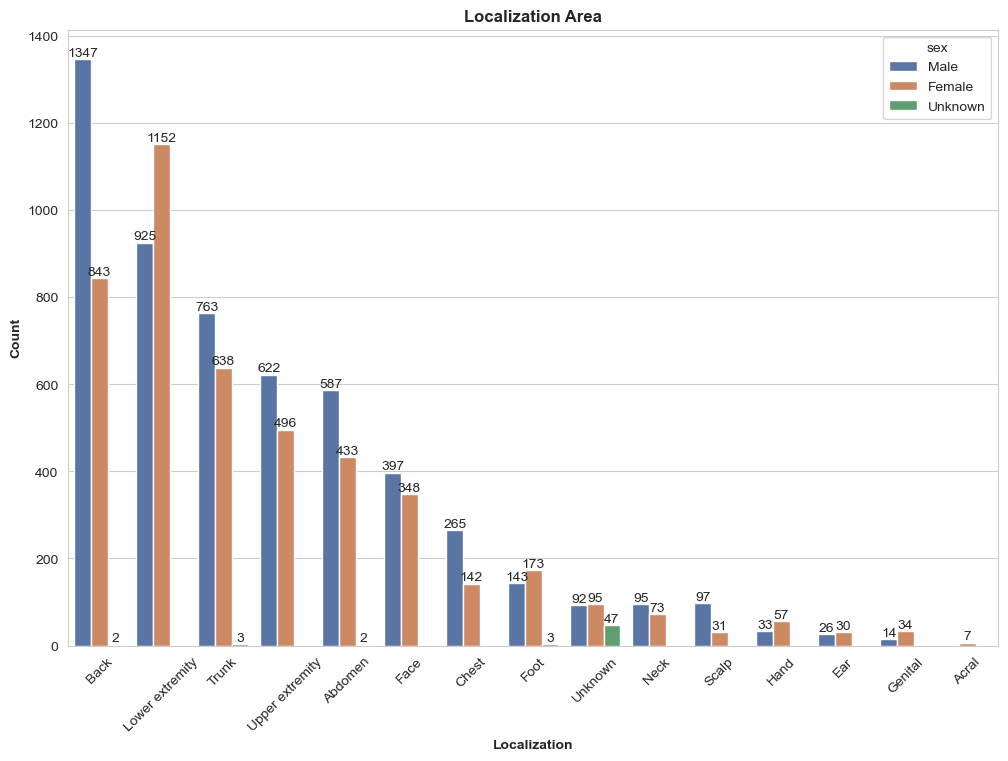

In [11]:
EDA_plots(data=metadata, variable="localization", hue="sex", title="Localization Area")

Men exhibit skin lesions in more than 50% of the time compared to women. On the other hand, for women, the most frequent place for skin lesions are the lower extrimities.

### Gender distribution

Lets see the distribution of males and females

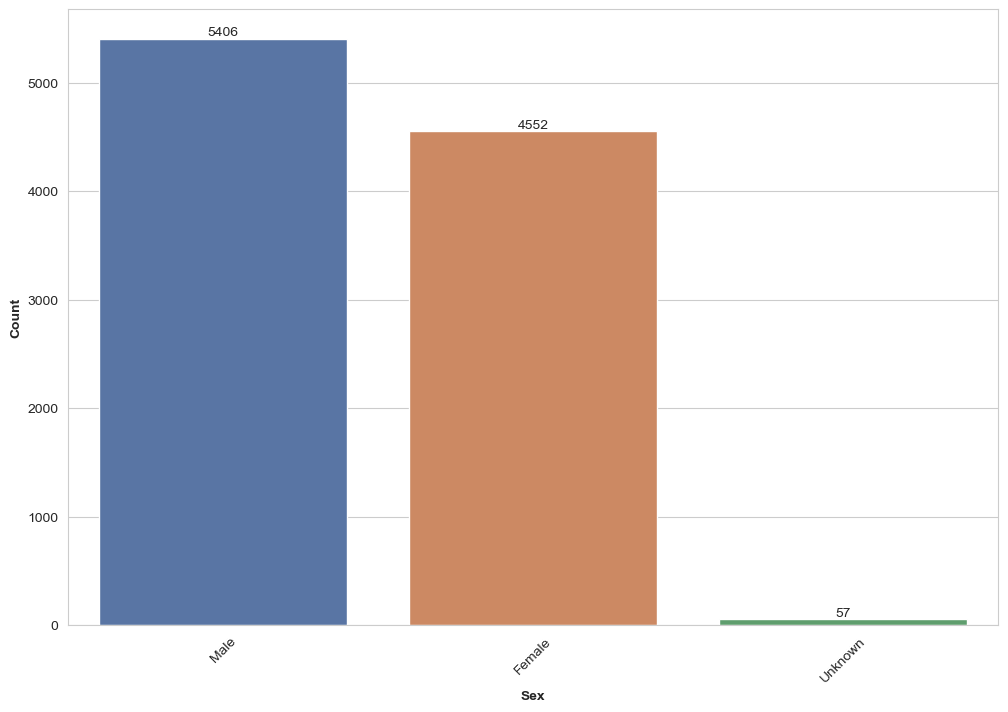

In [12]:
EDA_plots(data=metadata, variable="sex")

### Age distribution

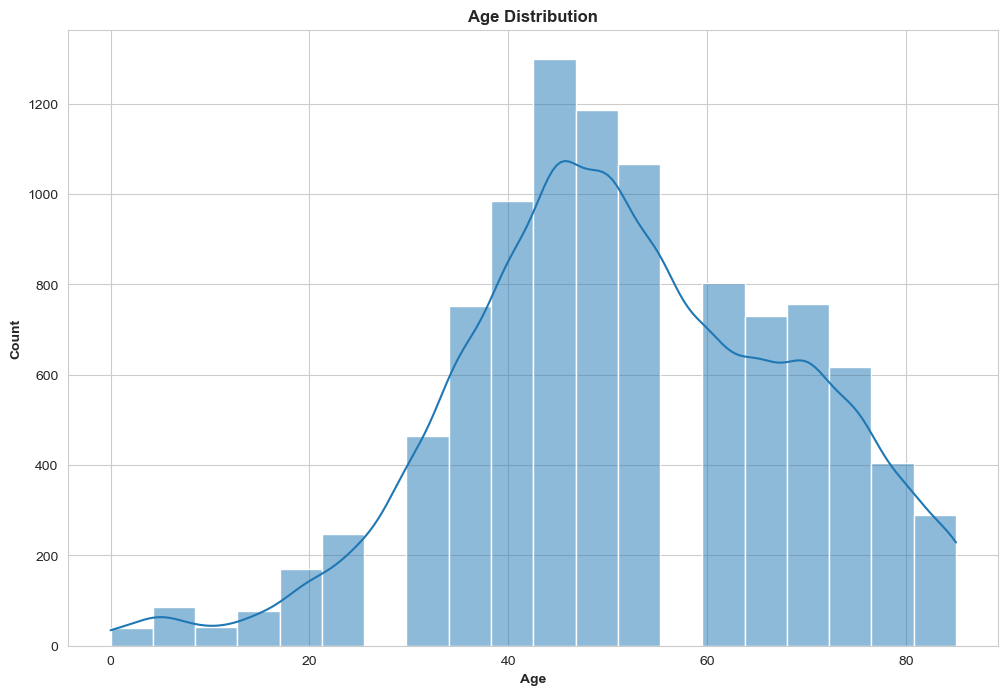

In [13]:
EDA_plots(data=metadata, variable="age", kind="hist", title="Age Distribution", hist_args={"kde": True, "bins": 20})

We can also look at the age distribution by gender.

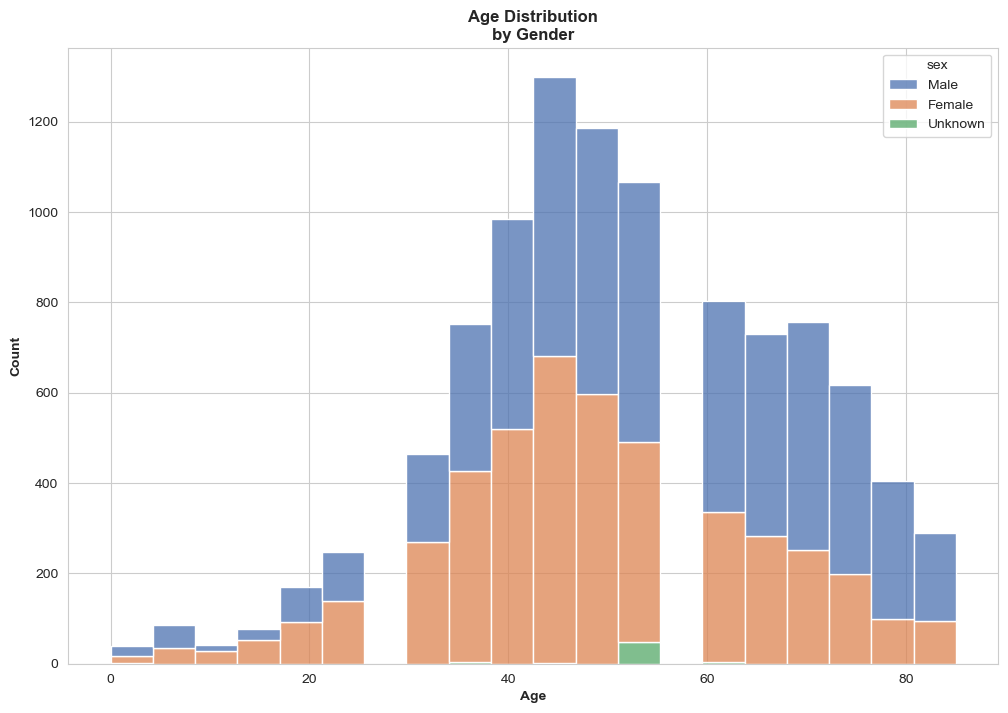

In [14]:
EDA_plots(data=metadata, variable="age", hue="sex", kind="hist", title="Age Distribution\nby Gender", hist_args={"kde": False, "bins": 20, "multiple": "stack"})

### Diagnosis by gender

In [15]:
for gender in metadata.sex.unique():
    print(f"Gender: {gender}")
    subset = metadata[metadata.sex == gender].groupby("dx").size().reset_index().rename(columns={0: "#"})
    subset["%"] = (subset["#"] / subset["#"].sum()).round(2)
    display(subset.sort_values("#", ascending=False))
    print("\n")

Gender: Male


dx     #     %
4               Melanocytic nevi  3421  0.63
5                       Melanoma   689  0.13
2  Benign keratosis-like lesions   626  0.12
1           Basal cell carcinoma   317  0.06
0              Actinic keratoses   221  0.04
6               Vascular lesions    69  0.01
3                 Dermatofibroma    63  0.01



Gender: Female


dx     #     %
4               Melanocytic nevi  3237  0.71
2  Benign keratosis-like lesions   463  0.10
5                       Melanoma   424  0.09
1           Basal cell carcinoma   197  0.04
0              Actinic keratoses   106  0.02
6               Vascular lesions    73  0.02
3                 Dermatofibroma    52  0.01



Gender: Unknown


dx   #     %
1               Melanocytic nevi  47  0.82
0  Benign keratosis-like lesions  10  0.18

### Visual inspection of images

Since we are dealing with image data, it is also useful to visually inspect a sample of them.

#### Resizing images

For computing efficiency, we resize the images from 600 x 450 px into 100 x 75 px.

In [16]:
if LOAD_DATA:
    metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
    np.save("image_arrays_HAM.npy", metadata["image"].to_numpy(), allow_pickle=True)
else:
    metadata['image'] = np.load("image_arrays_HAM.npy", allow_pickle=True)

Showing a random sample of 5 lesions per diagnosis.

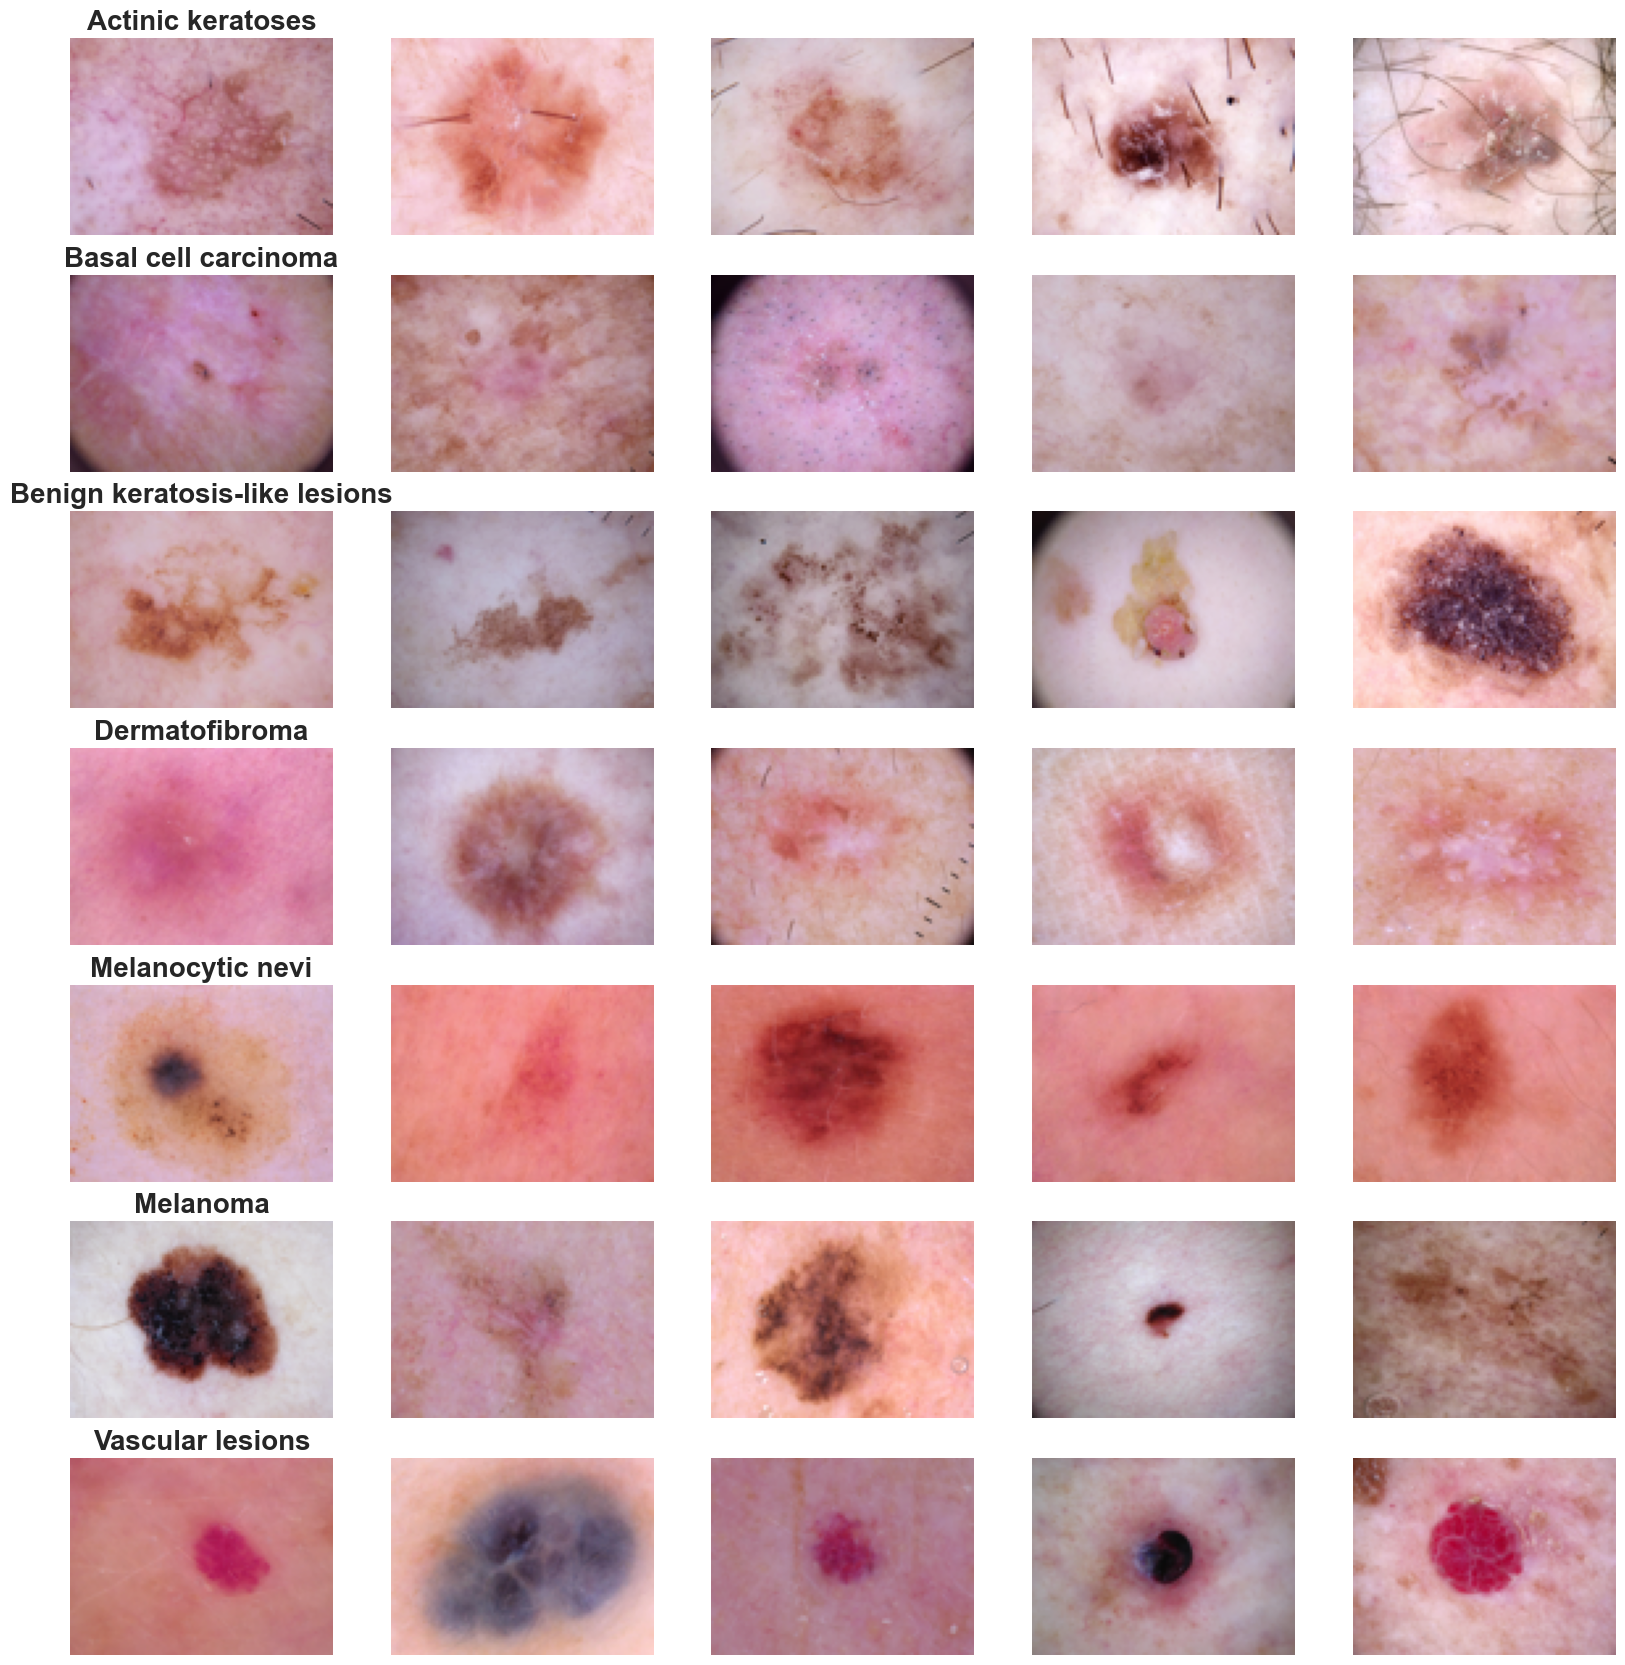

In [17]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         metadata.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name, fontsize=20, weight="bold")
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=SEED).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
#fig.savefig('../images/lesion_samples.png', dpi=300)

## Data Preprocessing

### Data split

Since there are cases with multiple different images for the same lesion, to avoid data leakage we need to keep images from the same lesion together. We will do that by randomly splitting on lesion_id and then matching all images from a given lesion_id. 

In [18]:
# Extract unique lesion ids
lesion_ids = metadata.lesion_id.unique()

# Split unique lesion ids into train and validation
X_train_id, X_val_id = train_test_split(lesion_ids, test_size = 0.20, random_state=SEED)

# Split the data by ids
train = metadata[metadata.lesion_id.isin(X_train_id)]
valid = metadata[metadata.lesion_id.isin(X_val_id)]

# Extract features and labels for train and validation
X_train = train["image"]
y_train = train['dx'].map({i: k for k, v in mapping["cancer"].items() for i in v})

X_val = valid["image"]
y_val = valid['dx'].map({i: k for k, v in mapping["cancer"].items() for i in v})

In [19]:
print(f"The training data contains {y_train[y_train == 0].shape[0]} cancer instances and {y_train[y_train == 1].shape[0]} non-cancer instances.")

The training data contains 6712 cancer instances and 1315 non-cancer instances.


### Standardization

We normalize the features Train and Test sets by substracting the mean and dividing by the standard deviation.

In [20]:
X_train = np.asarray(X_train.tolist())
X_val_ix = X_val.index
X_val = np.asarray(X_val.tolist())

X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std

### Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. But we want to encode these lables to one hot vectors in a binary fashion: Cancer or Non-Cancer.

In [21]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

### Reshape back to 3-channel image

Since we had flatten the arrays to perform standardization, we now reshape back to  3 dimensions (height = 75px, width = 100px , canal = 3)

In [22]:
X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_val = X_val.reshape(X_val.shape[0], *(75, 100, 3))

## Classifier

### Model Building: CNN

We will use a CNN with the following architecture:
 - Convolutional layers of 32 filters (x2) and 64 filters (x2)
 - Max-Pool layers
 - Dropout layers for regularization
 - ReLu activation functions
 - Softmax function for final probabilities

In [23]:
model = build_CNN(input_shape = (75, 100, 3),  num_classes = 2, metrics = [keras.metrics.AUC(), keras.metrics.F1Score(average="weighted")])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,354 (14.31 MB)

 Trainable params: 3,752,354 (14.31 MB)

 Non-trainable params: 0 (0.00 B)

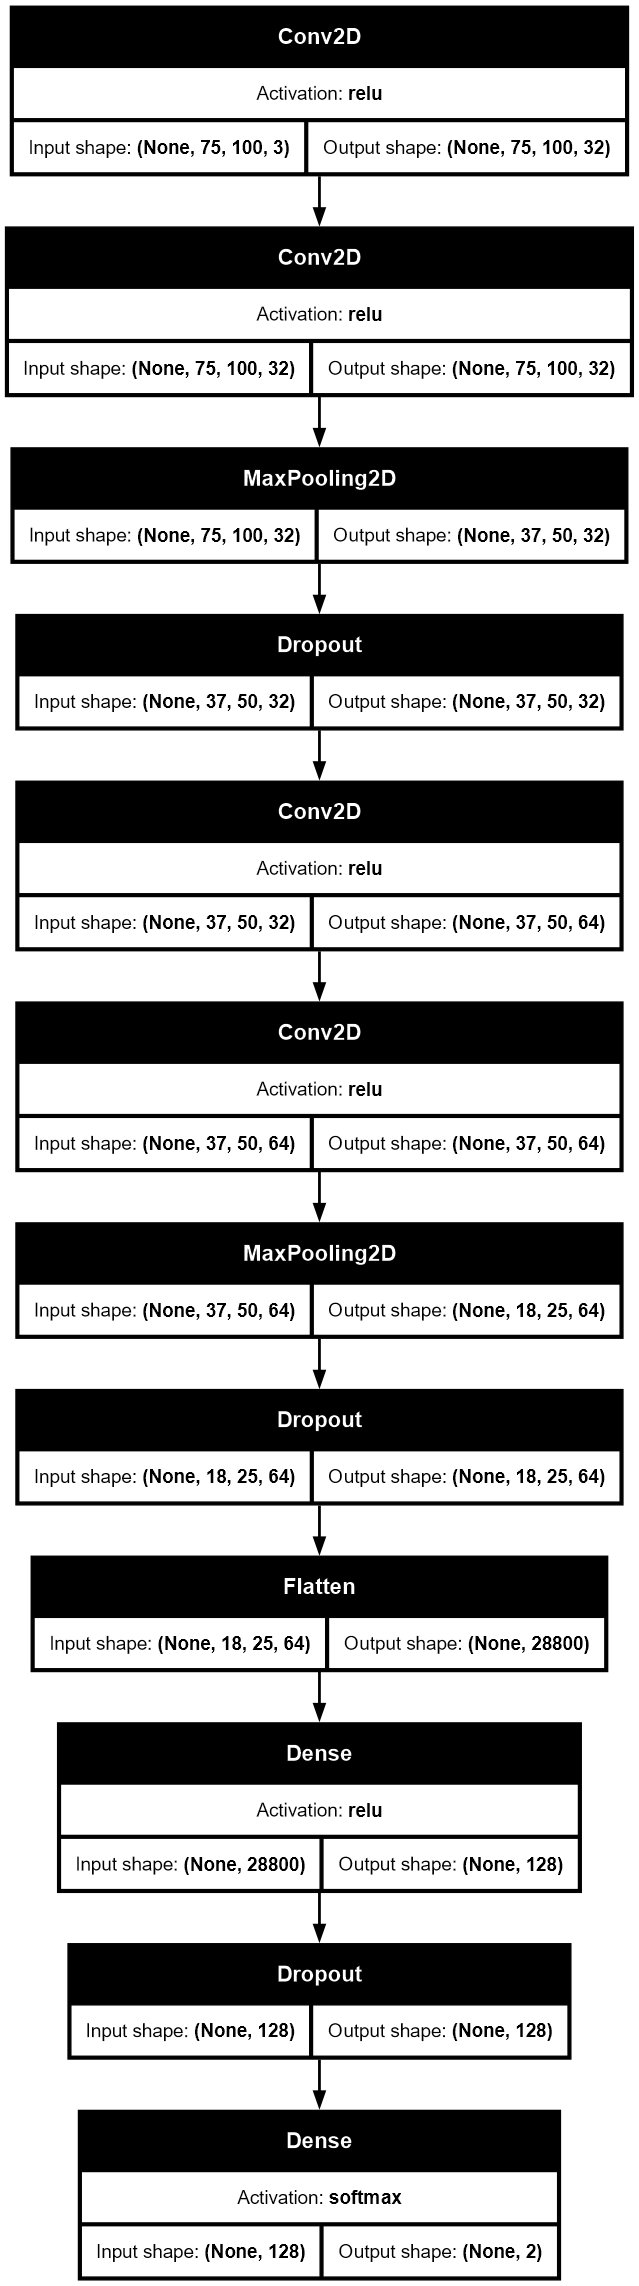

In [24]:
plot_model(model, to_file='../images/model_plot.png', rankdir="TB", show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=100)

### Data Augmentation

To avoid overfitting, we expand artificially our training data by data augmentation. This sould also aid the cross-dataset approach we are aiming to apply here. We will only apply small degree rotations, zoomming, width and height shifts.

In [25]:
# Data augmentation to prevent overfitting 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train, seed=SEED)

### Training the model

For efficiency, a previously trained model is saved as "model.keras". If you prefer to re-train the model from scratch, set the flag to TRUE. 

NOTE: If the model is not saved, the training will begin automatically.

In [26]:
if not TRAIN:
    try:
        print("Trying to load a saved model...")
        latest = [x for x in os.listdir() if x.startswith(f"model_v{len([x for x in os.listdir('.') if x.endswith('.keras')])}")][0]
        model = keras.models.load_model(latest)
        model_history = json.loads(open(f"train_history_{latest.removeprefix('model_').removesuffix('.keras')}.json").read())
        print("Model successfully loaded.")
    except:
        print("Couldn't load model. Training again...")
        TRAIN = True

if TRAIN:
    # Fit the model
    epochs = 40
    batch_size = 10
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_hogehoge', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size*3, seed=SEED),
                                epochs = epochs, validation_data = (X_val , y_val),
                                verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, 
                                callbacks=[learning_rate_reduction])
    
    # Save trained model
    version = f'{len([x for x in os.listdir(".") if x.endswith(".keras")])+1}-{datetime.now().strftime("%Y%m%d")}'
    model.save(f"model_v{version}.keras")
    model_history = history.history

    # Save training history
    json_object = json.dumps(history.history)
    with open(f"train_history_v{version}.json", "w") as outfile:
        outfile.write(json_object)

Trying to load a saved model...
Model successfully loaded.


#### Train History

We plot the train history to check for underfitting/overfitting.

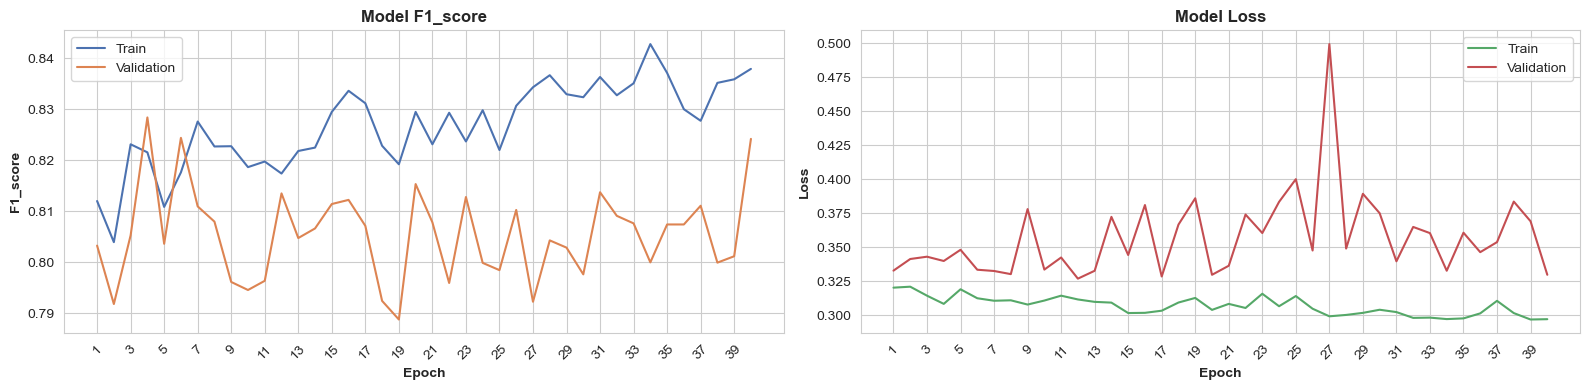

In [27]:
plot_model_train_history(model_history, metric="f1_score")

### Model Evaluation

We check the F1-Score and Loss for the training and validation datasets, along with the final loss and AUC.

In [28]:
results = model.evaluate(X_val, y_val, verbose=1, return_dict=True)

print(f"Validation: AUC = {results['auc']:.2f}  | F1-Score: {results['f1_score']:.2f} | Loss = {results['loss']:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - auc: 0.8684 - f1_score: 0.7541 - loss: 0.4547
Validation: AUC = 0.93  | F1-Score: 0.82 | Loss = 0.33


#### Main performance metrics, Confusion Matrix and Precision-Recall curve

We also plot the confusion matrix, to have more insights into the misclassifications.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = None >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.87      0.96      0.91      1676
      Cancer       0.53      0.25      0.34       312

    accuracy                           0.85      1988
   macro avg       0.70      0.61      0.63      1988
weighted avg       0.82      0.85      0.82      1988

MCC: 0.29


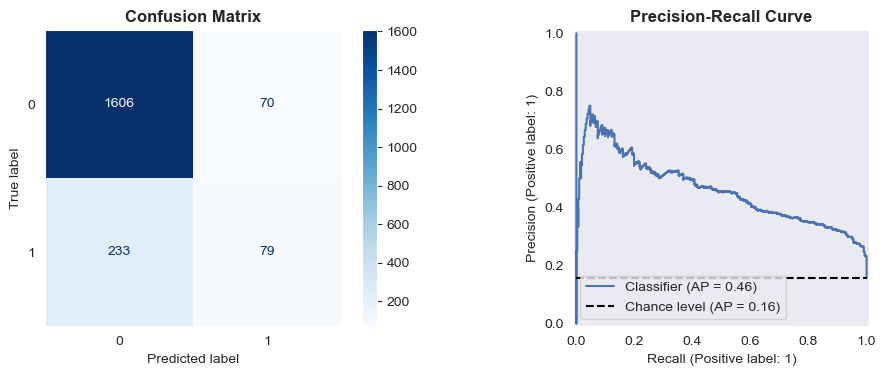

In [29]:
evaluate_model(model, X_val, y_test=y_val)

We can observe that the classifier has good accuracy and precision, but poor recall on Cancer. This is sub-optimal, since we would like the classifier to catch most of the cancer lesions, even if that means less accuracy. We can try to adjust the threshold to improve the recall of class 1.

#### Modified Threshold

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.97      0.66      0.78      1676
      Cancer       0.32      0.89      0.47       312

    accuracy                           0.69      1988
   macro avg       0.65      0.77      0.63      1988
weighted avg       0.87      0.69      0.73      1988

MCC: 0.40


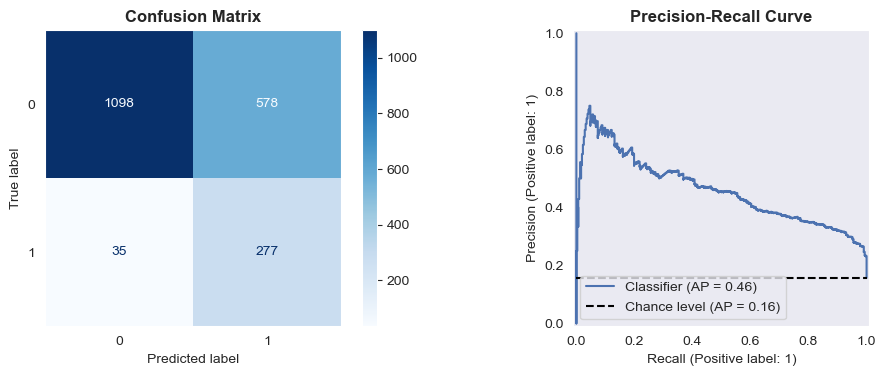

In [30]:
evaluate_model(model, X_val, y_test=y_val, threshold=0.1)

We can see that adjusting the threshold to 0.1 improves greatly the recall for class cancer, while reducing drastically precision (this is an inevitable trade-off) and losing also some accuracy.

#### Mis-classified images

Finally, we'll visually inspect some of the mis-classified lesions for insights.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


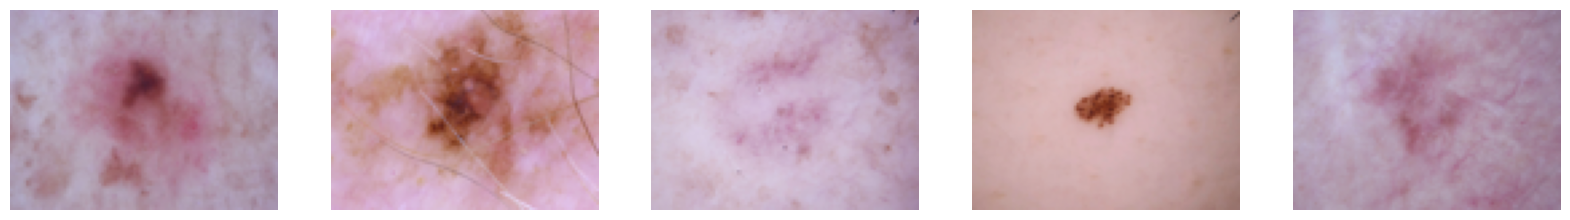

In [31]:
y_pred = np.argmax(model.predict(X_val), axis = 1)
y_true = np.argmax(y_val, axis = 1)

n_samples = 5
fig, ax = plt.subplots(1, n_samples, figsize = (4*n_samples, 4))

for ix, img in enumerate(metadata.loc[X_val_ix[y_pred !=  y_true], "image"].sample(n=5, random_state=SEED)):
    ax[ix].imshow(img)
    ax[ix].axis('off')

## Predictions

### Resize images to standard

Since our model takes as input 75x100 px images, we need to standardize all new images to that size, while preserving the lesion shape (since this is important for cancer classification). An example of image resizing can be seen below.

Original shape: (1050, 1050, 3)
Resizing without preserving shape: (75, 100, 3)
Resizing without while preserving shape: (75, 100, 3)


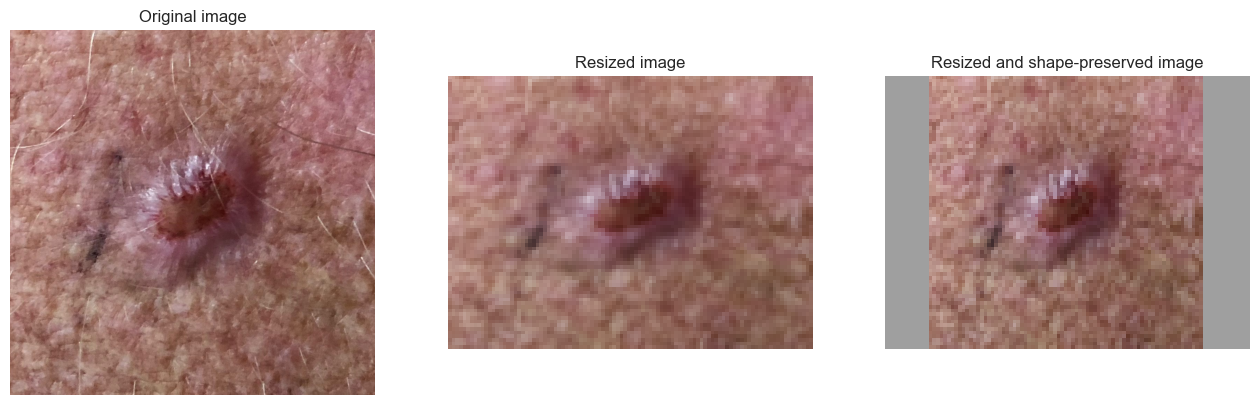

In [32]:
a = Image.open("../data/PAD-UFES-20/images/PAT_8_15_820.png").convert('RGB')
print(f"Original shape: {np.asarray(a).shape}")
b = resize(np.asarray(a), (75,100), order=None, mode='reflect', cval=0, clip=True, preserve_range=False, anti_aliasing=True, anti_aliasing_sigma=None)
print(f"Resizing without preserving shape: {np.asarray(b).shape}")
c = resize_with_padding(a, (100,75), fill_color=X_train_mean)
print(f"Resizing without while preserving shape: {np.asarray(c).shape}")

fig, ax = plt.subplots(1, 3, figsize=(16,6))

ax[0].imshow(a)
ax[0].axis('off')
ax[0].title.set_text("Original image")
ax[1].imshow(b)
ax[1].axis('off')
ax[1].title.set_text("Resized image")
ax[2].imshow(c)
ax[2].axis('off')
ax[2].title.set_text("Resized and shape-preserved image")

We see how the custom resizing preserves the image. We also can appreciate the reduction in image quality. We will now resize all images before proceeding.

In [33]:
# Load PAD-UFES-20 metadata
test_metadata = pd.read_csv(DATA + 'PAD-UFES-20/metadata.csv')
# Drop NAs from gender, diagnose and skin color
test_metadata.dropna(subset=["gender", "diagnostic", "fitspatrick"], inplace=True)
test_metadata.reset_index(drop=True, inplace=True) # We don't care about the old index-

# Mapping image ids to their path
imageid_path_dict = {os.path.basename(x): x
                     for x in glob(os.path.join(DATA+"PAD-UFES-20/images/", '*.png'))}

# Creating mapped columns for better readability
test_metadata['path'] = test_metadata['img_id'].map(imageid_path_dict.get)
test_metadata['dx'] = test_metadata['diagnostic'].str.lower().map(mapping["lesion_type"]) 
test_metadata["gender"] = test_metadata.gender.str.capitalize()
test_metadata["fitspatrick"] = test_metadata["fitspatrick"].map({i: k for k, v in mapping["fitspatrick"].items() for i in v})

In [34]:
# Load images
if LOAD_DATA:
    test_metadata['image'] = test_metadata['path'].map(lambda x: resize_with_padding(Image.open(x).convert("RGB"), (100, 75), fill_color=X_train_mean))
    np.save("image_arrays_PAD.npy", test_metadata["image"].to_numpy(), allow_pickle=True)
else:
    test_metadata['image'] = np.load("image_arrays_PAD.npy", allow_pickle=True)

# Extract features and labels for test dataset
X_test = test_metadata["image"]
y_test = test_metadata['dx'].map({i: k for k, v in mapping["cancer"].items() for i in v})

### Standardization

We normalize the features Train and Test sets by substracting the mean and dividing by the standard deviation.

In [35]:
X_test = np.asarray(X_test.tolist())
X_test = (X_test - X_train_mean)/X_train_std

### Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. But we want to encode these lables to one hot vectors in a binary fashion: Cancer or Non-Cancer.

In [36]:
# Perform one-hot encoding on the labels
y_test = to_categorical(y_test, num_classes = 2)

### Reshape back to 3-channel image

Since we had flatten the arrays to perform standardization, we now reshape back to  3 dimensions (height = 75px, width = 100px , canal = 3)

In [37]:
X_test = X_test.reshape(1494, *(75, 100, 3))

## Evaluate the model on the test data

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.29      0.90      0.43       405
      Cancer       0.81      0.17      0.28      1089

    accuracy                           0.37      1494
   macro avg       0.55      0.53      0.36      1494
weighted avg       0.67      0.37      0.32      1494

MCC: 0.08


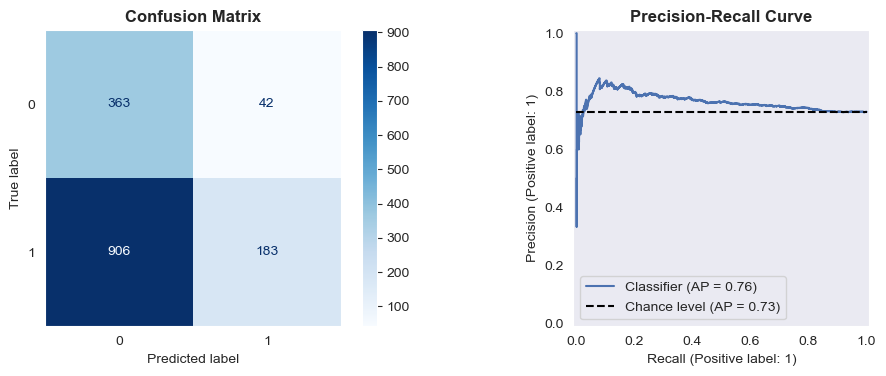

In [38]:
evaluate_model(model, X_test, y_test=y_test, threshold=0.1)

Checking the AUC for the model on test data.

In [39]:
roc_auc_score(y_test, model.predict(X_test))

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


0.5524714031448038

### Evaluation by groups

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.27      0.90      0.42       366
      Cancer       0.83      0.17      0.28      1055

    accuracy                           0.36      1421
   macro avg       0.55      0.53      0.35      1421
weighted avg       0.69      0.36      0.32      1421

MCC: 0.08


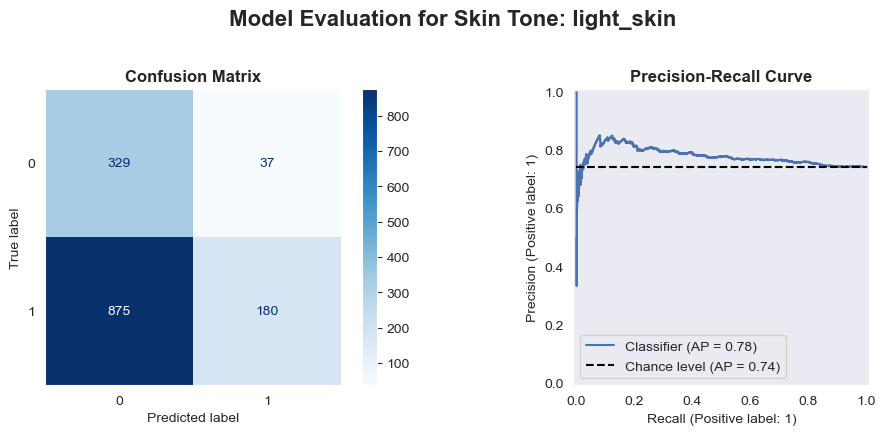

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.52      0.87      0.65        39
      Cancer       0.38      0.09      0.14        34

    accuracy                           0.51        73
   macro avg       0.45      0.48      0.40        73
weighted avg       0.45      0.51      0.42        73

MCC: -0.06


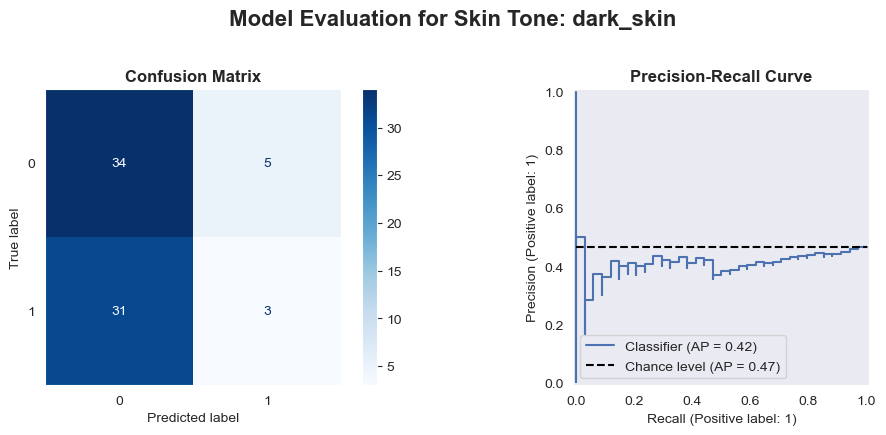

In [40]:
for skin_tone in test_metadata.fitspatrick.unique():
    subset = test_metadata[test_metadata.fitspatrick == skin_tone].index
    evaluate_model(model, X_test[subset], y_test=y_test[subset], threshold=0.1, title=f"Model Evaluation for Skin Tone: {skin_tone}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.32      0.89      0.47       229
      Cancer       0.77      0.17      0.28       524

    accuracy                           0.39       753
   macro avg       0.54      0.53      0.37       753
weighted avg       0.63      0.39      0.33       753

MCC: 0.07


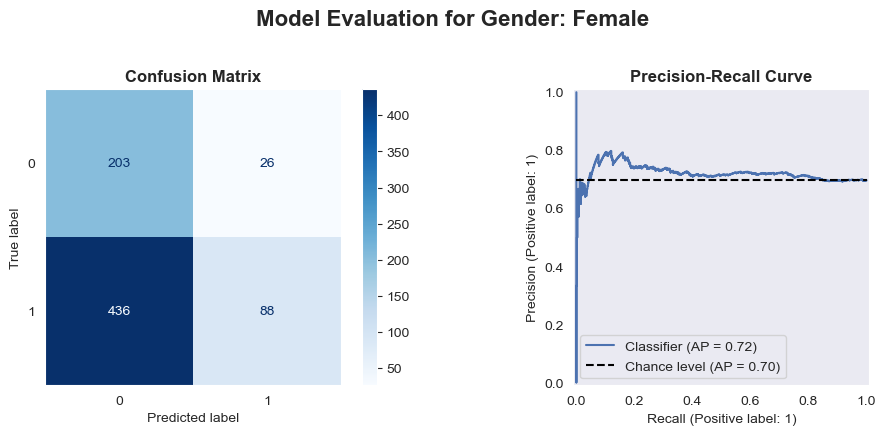

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.25      0.91      0.40       176
      Cancer       0.86      0.17      0.28       565

    accuracy                           0.34       741
   macro avg       0.55      0.54      0.34       741
weighted avg       0.71      0.34      0.31       741

MCC: 0.09


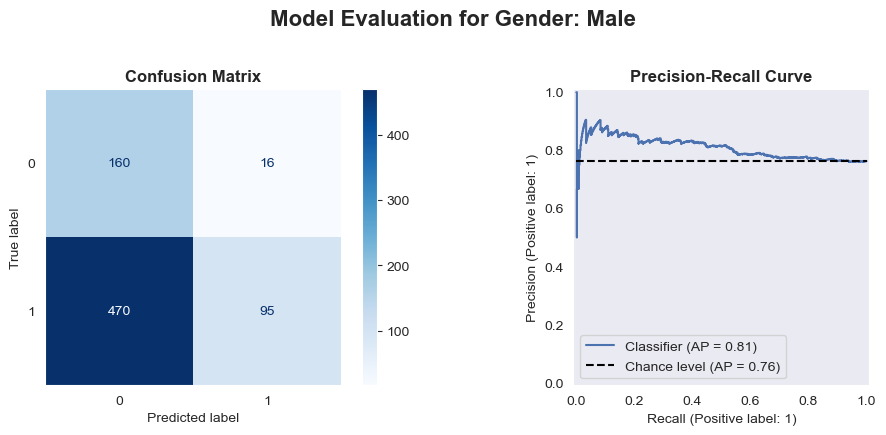

In [41]:
for sex in test_metadata.gender.unique():
    subset = test_metadata[test_metadata.gender == sex].index
    evaluate_model(model, X_test[subset], y_test=y_test[subset], threshold=0.1, title=f"Model Evaluation for Gender: {sex.capitalize()}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.31      0.89      0.46       210
      Cancer       0.79      0.17      0.28       508

    accuracy                           0.38       718
   macro avg       0.55      0.53      0.37       718
weighted avg       0.65      0.38      0.33       718

MCC: 0.08


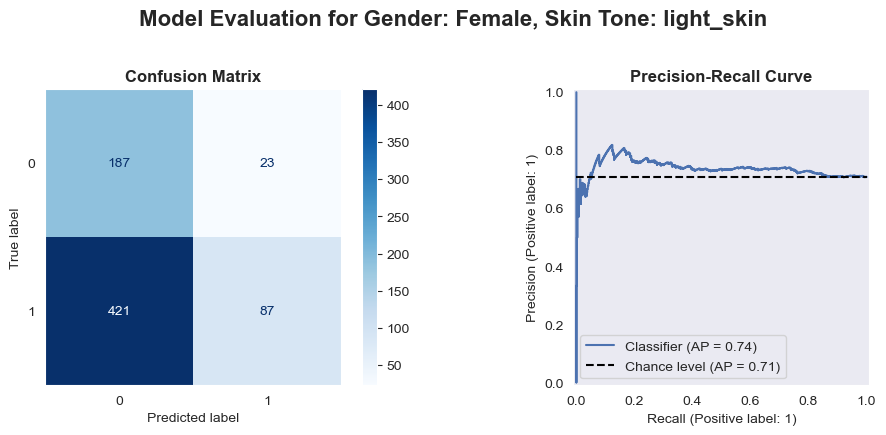

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.52      0.84      0.64        19
      Cancer       0.25      0.06      0.10        16

    accuracy                           0.49        35
   macro avg       0.38      0.45      0.37        35
weighted avg       0.39      0.49      0.39        35

MCC: -0.15


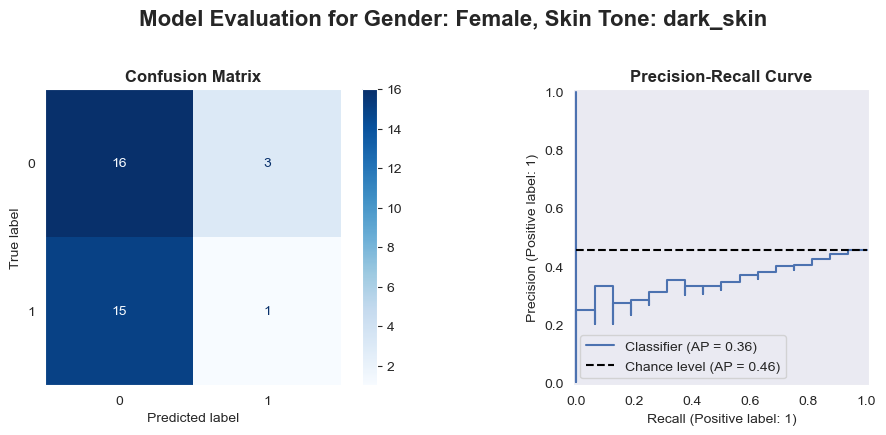

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.24      0.91      0.38       156
      Cancer       0.87      0.17      0.28       547

    accuracy                           0.33       703
   macro avg       0.55      0.54      0.33       703
weighted avg       0.73      0.33      0.31       703

MCC: 0.09


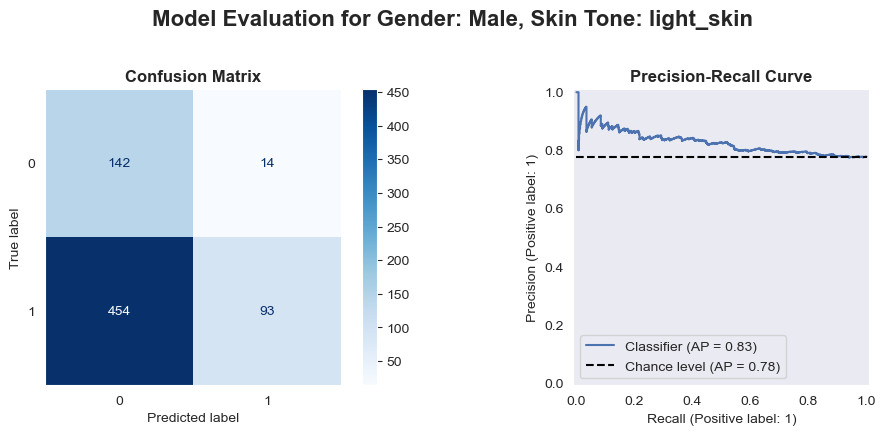

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
<<<<<<<<<< MODEL EVALUATION | Threshold = 0.1 >>>>>>>>>>

              precision    recall  f1-score   support

  Non-Cancer       0.53      0.90      0.67        20
      Cancer       0.50      0.11      0.18        18

    accuracy                           0.53        38
   macro avg       0.51      0.51      0.42        38
weighted avg       0.52      0.53      0.44        38

MCC: 0.02


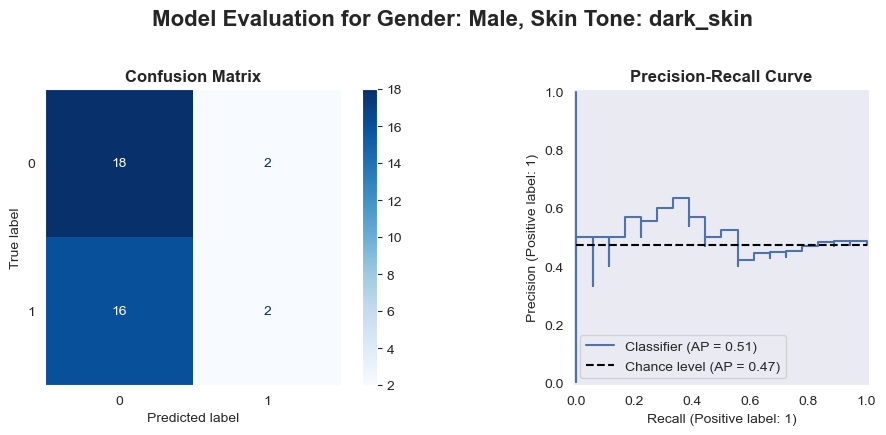

In [42]:
for sex in test_metadata.gender.unique():
    for skin_tone in test_metadata.fitspatrick.unique():
        subset = test_metadata[(test_metadata.gender == sex) & (test_metadata.fitspatrick == skin_tone)].index
        evaluate_model(model, X_test[subset], y_test=y_test[subset], threshold=0.1, title=f"Model Evaluation for Gender: {sex.capitalize()}, Skin Tone: {skin_tone}")

## Fairness assessment

We use our FairnessReport class to look at the group-wise results and check for fairness.

In [43]:
# Extract the class probabilites from model on test data
y_hat = model.predict(X_test)
# Transform class probabilities to labels (giving a treshold)
y_pred_labels = [1 if prob > 0.1 else 0 for prob in np.ravel(y_hat[:, 1])]
# Create Fairness Report instance
fr = FairnessReport()

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


### Skin Tone/Type

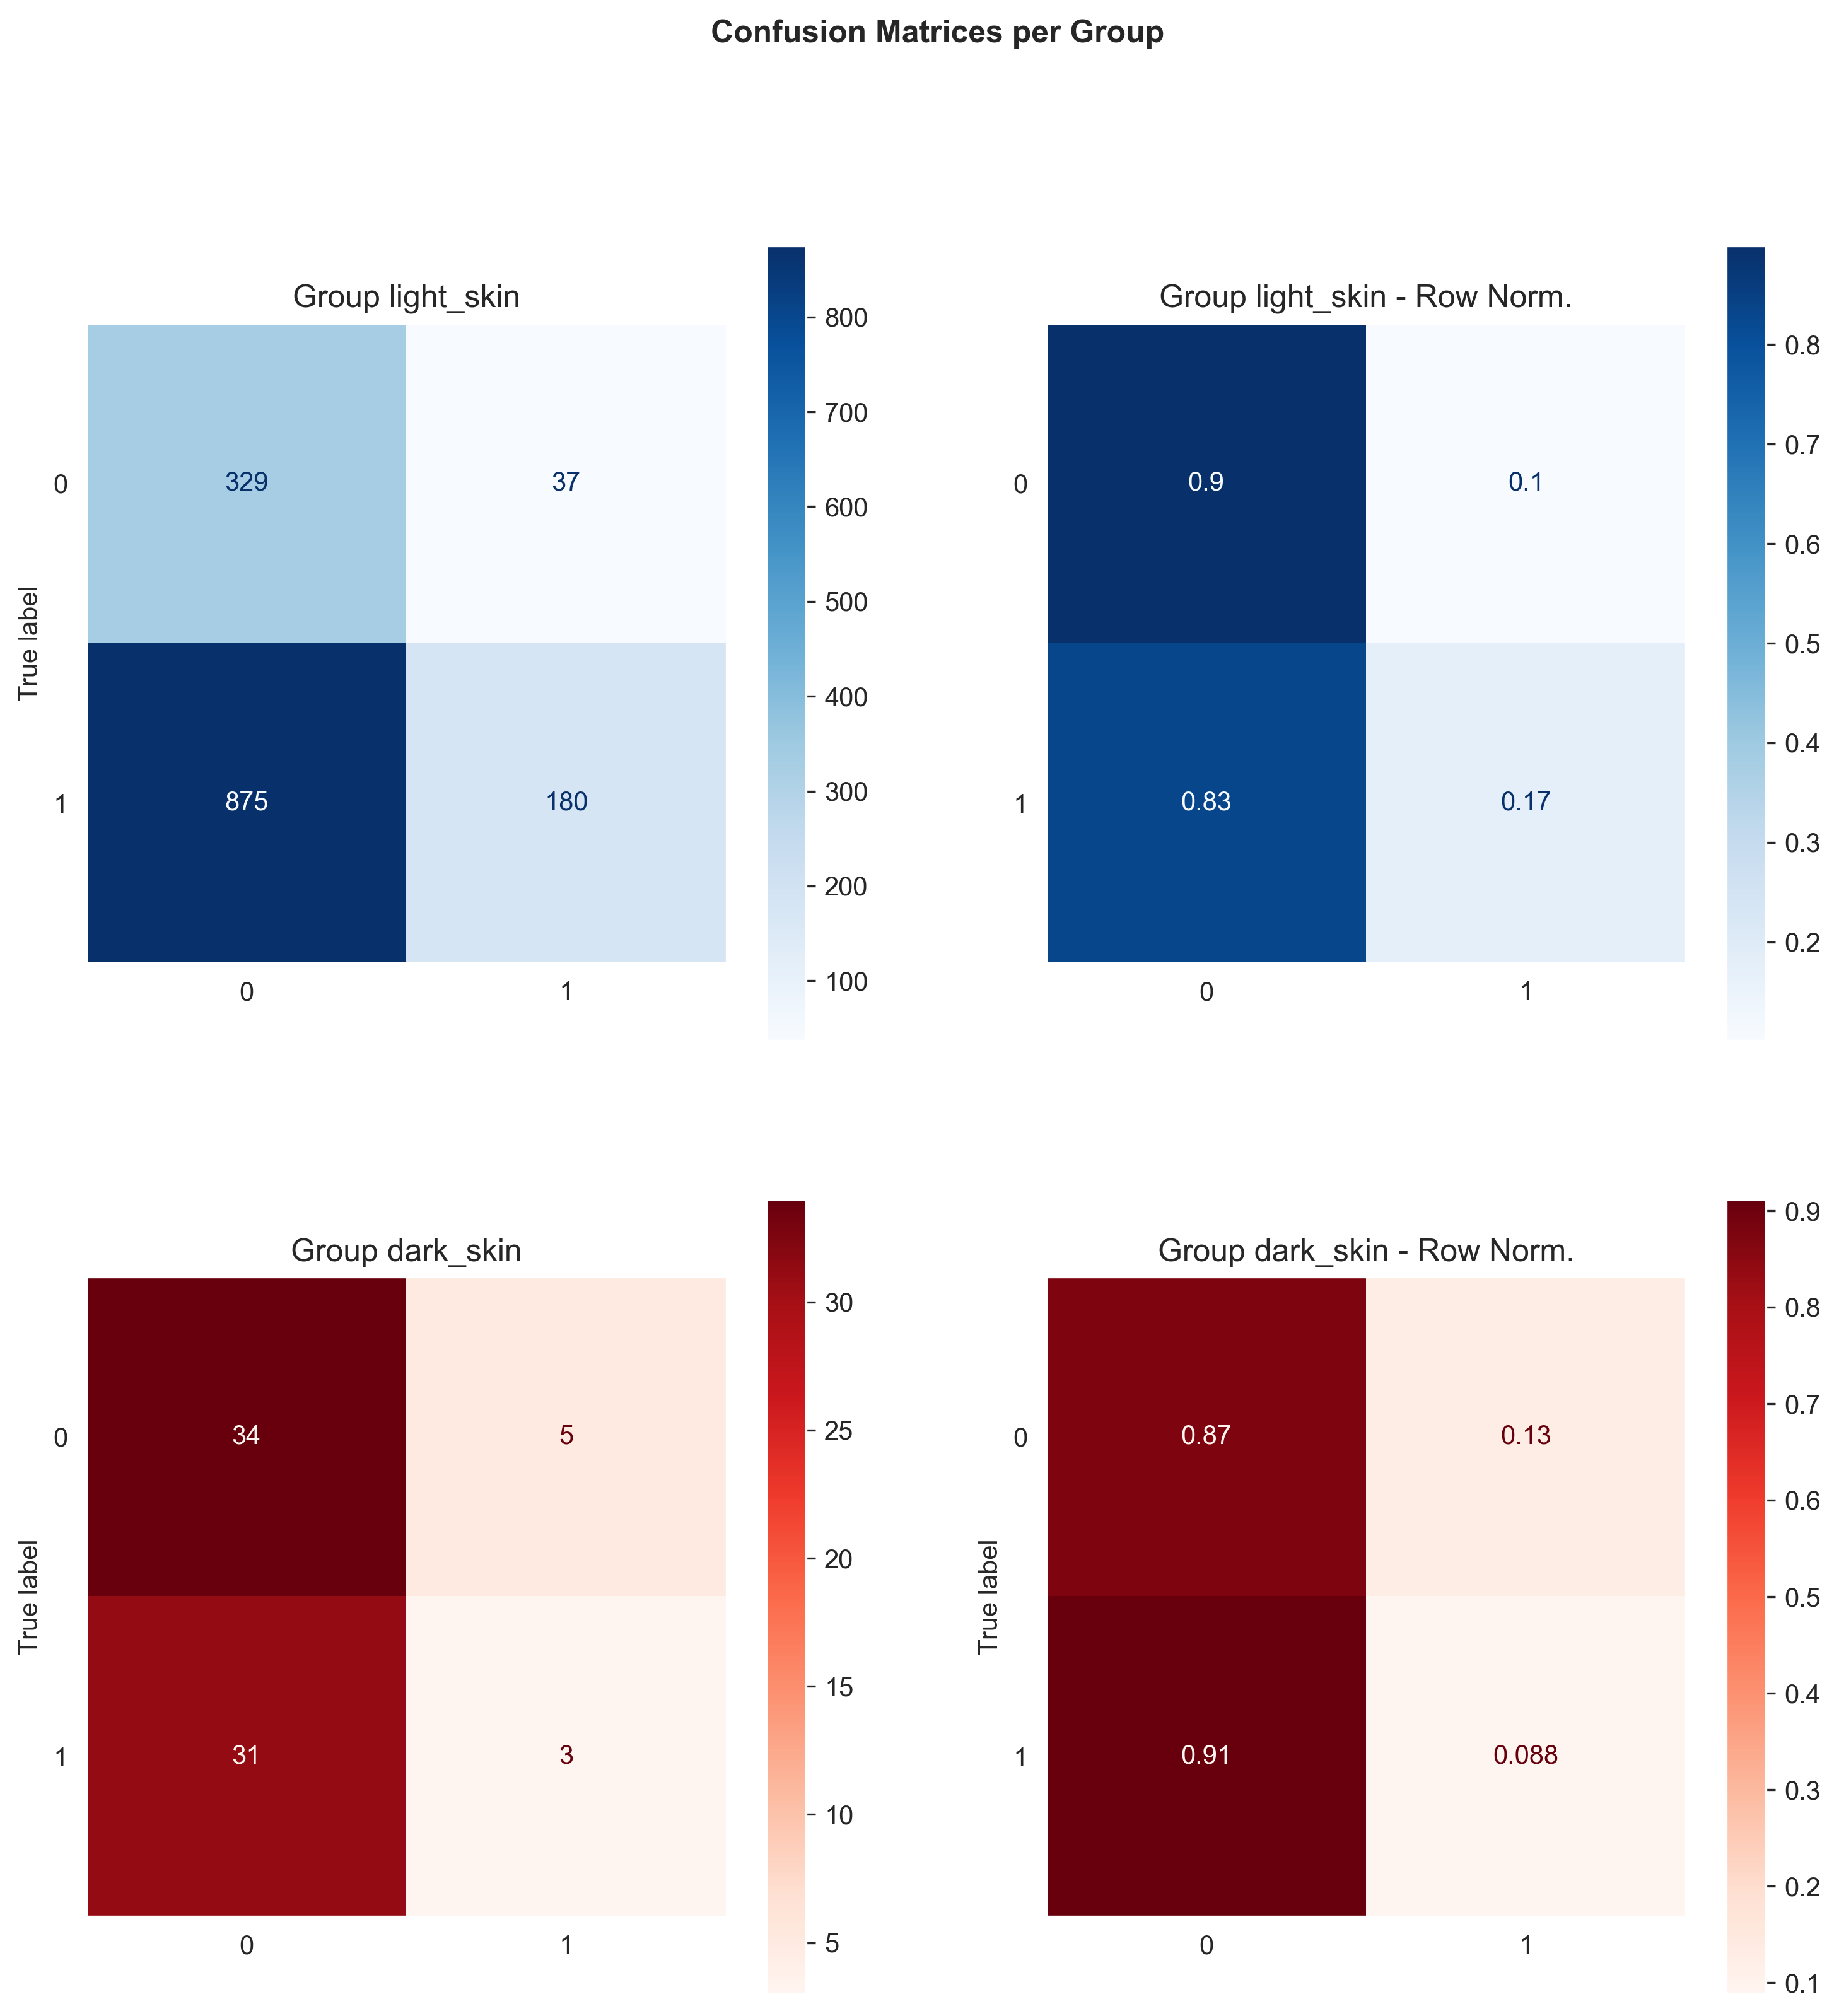

Statistical Parity: False -> P(s=1 | G=light_skin): 0.153 & P(s=1 | G=dark_skin): 0.110
Equalized Odds: False -> TPR Group light_skin: 0.171 & FPR Group light_skin: 0.101 & TPR Group dark_skin: 0.088 & FPR Group dark_skin: 0.128
Equalized Outcomes: False -> P(T=1 | G=light_skin, S=1): 0.829 & P(T=1 | G=light_skin, S=0): 0.727 & P(T=1 | G=dark_skin, S=1): 0.375 & P(T=1 | G=dark_skin, S=0): 0.477


In [44]:
fr.fit(y_true = np.argmax(y_test, axis=1), y_pred = y_pred_labels, group = test_metadata["fitspatrick"], pred_prob = y_hat, index=test_metadata.index)
fr.compute()

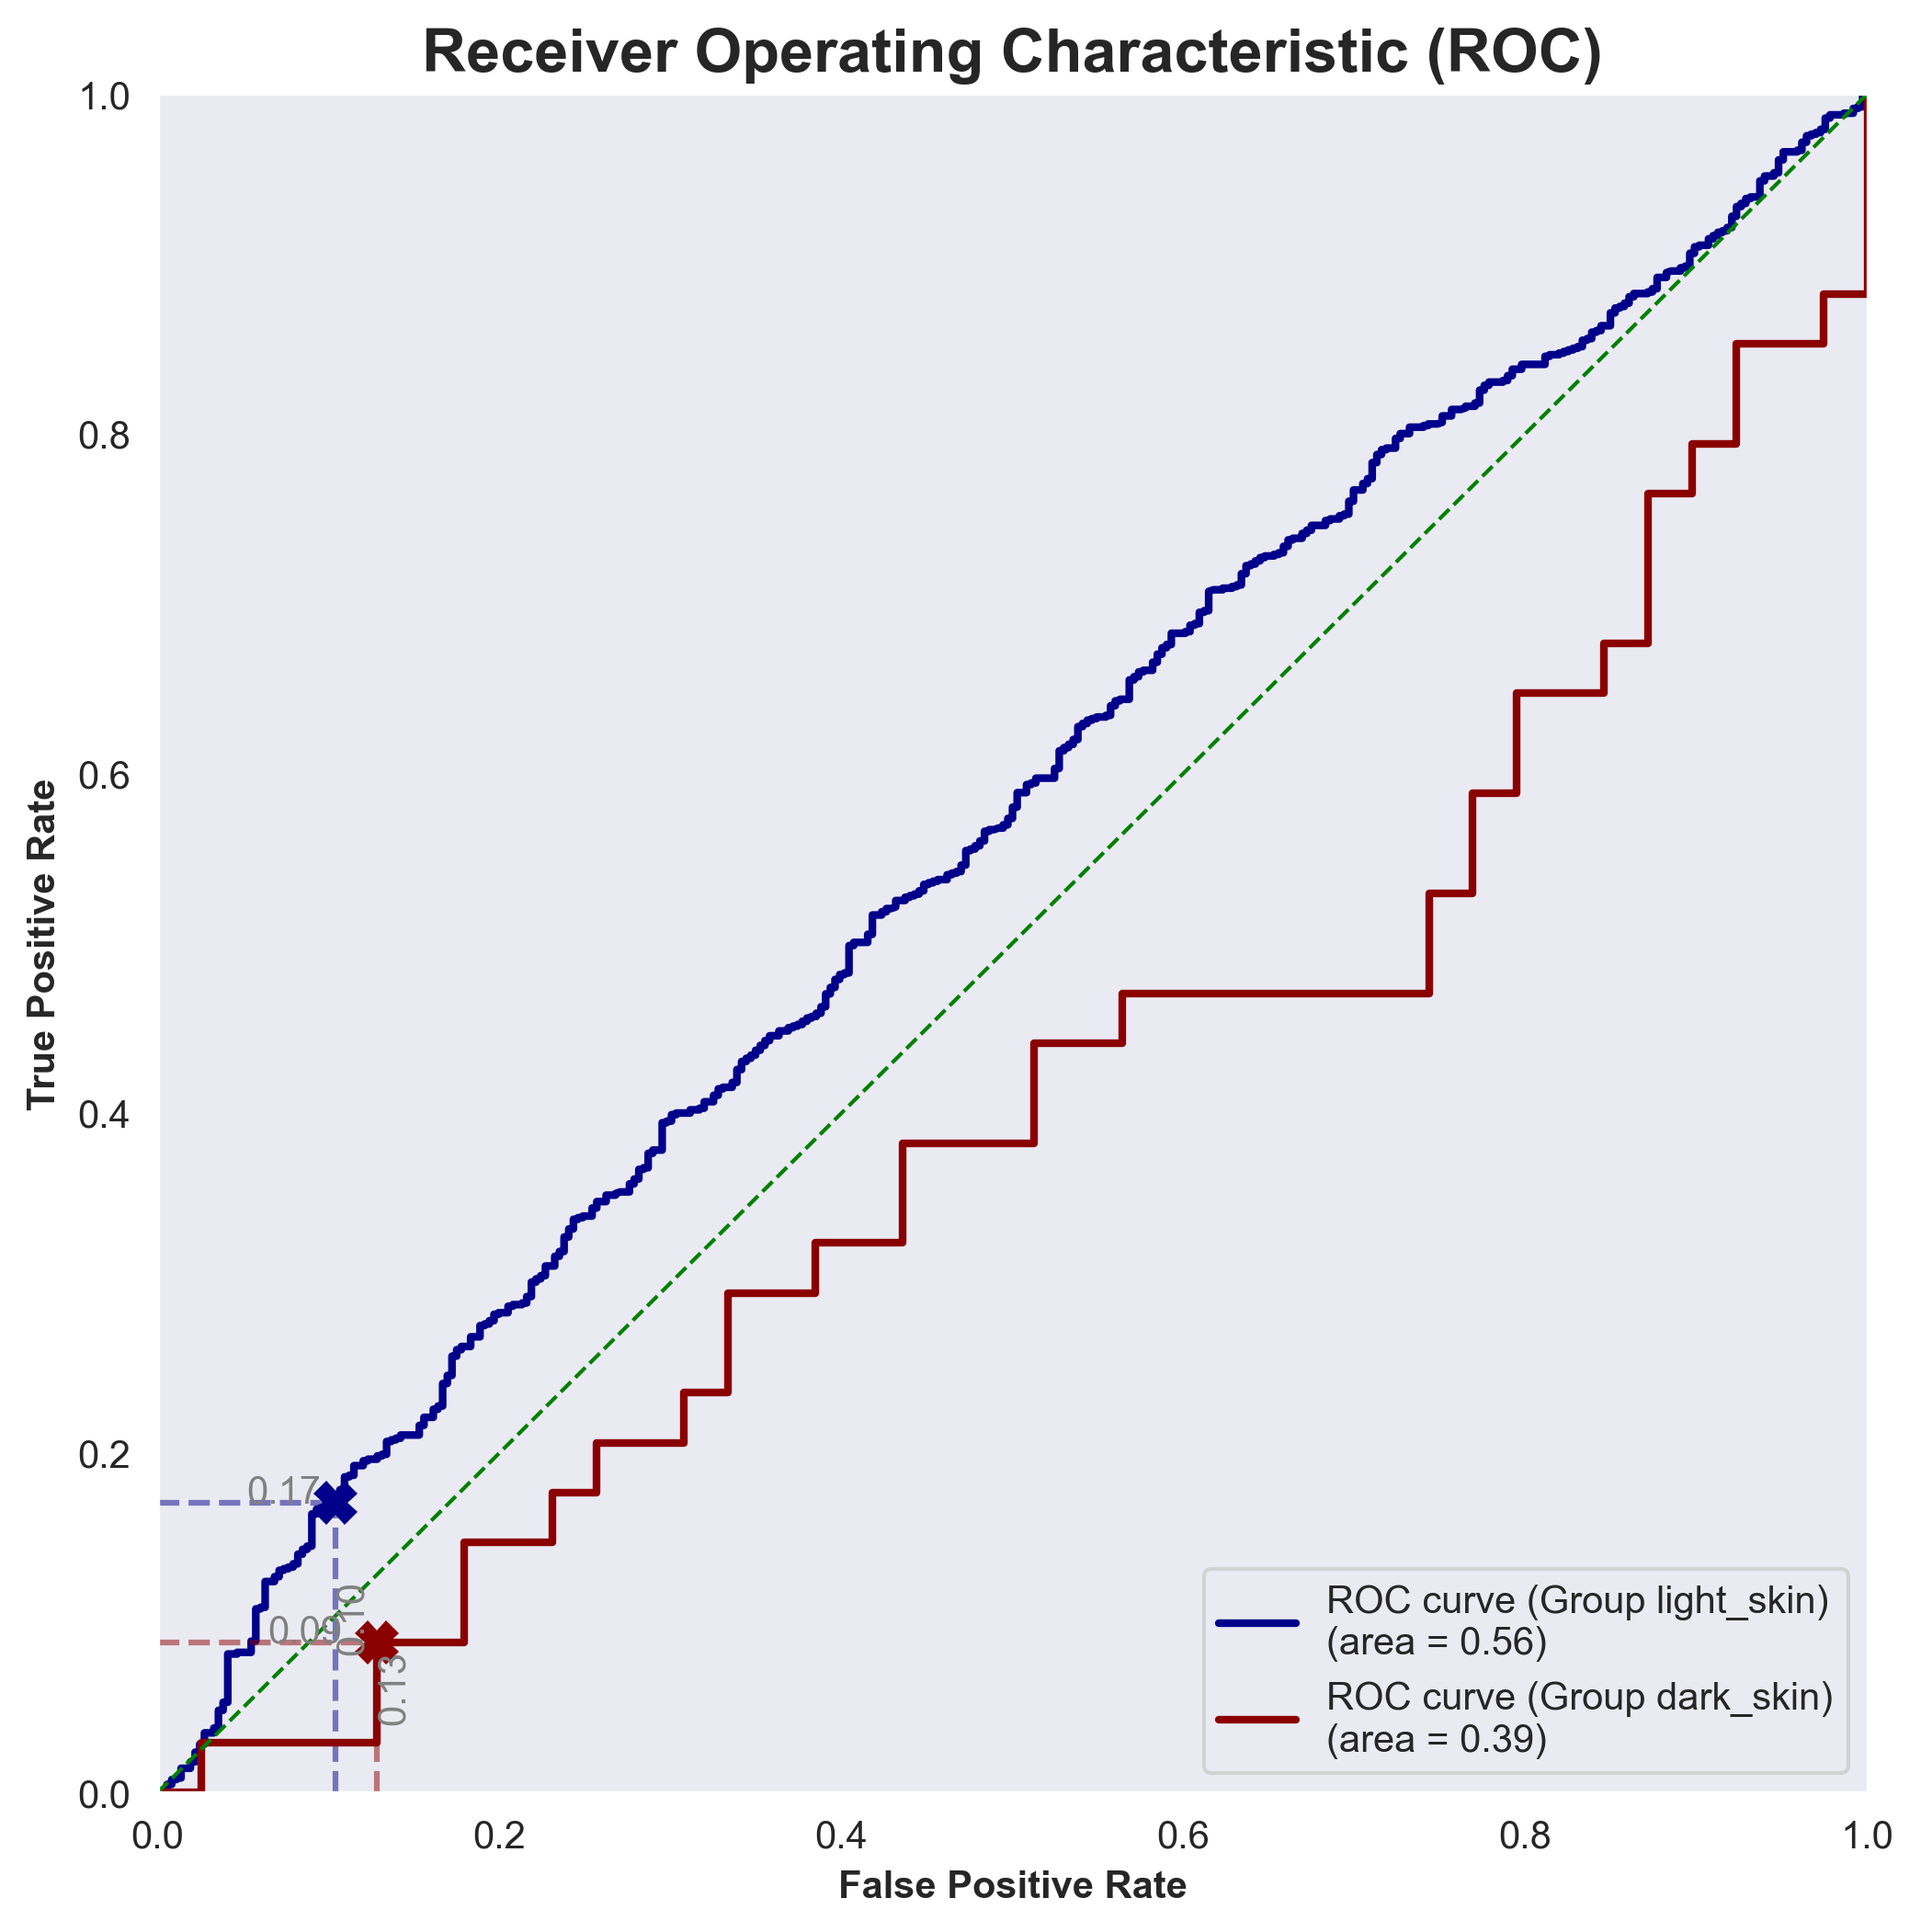

In [45]:
fr.plot_roc_curves(highlight = {"light_skin": 0.1, "dark_skin": 0.1}, save="skin.png")

### Gender

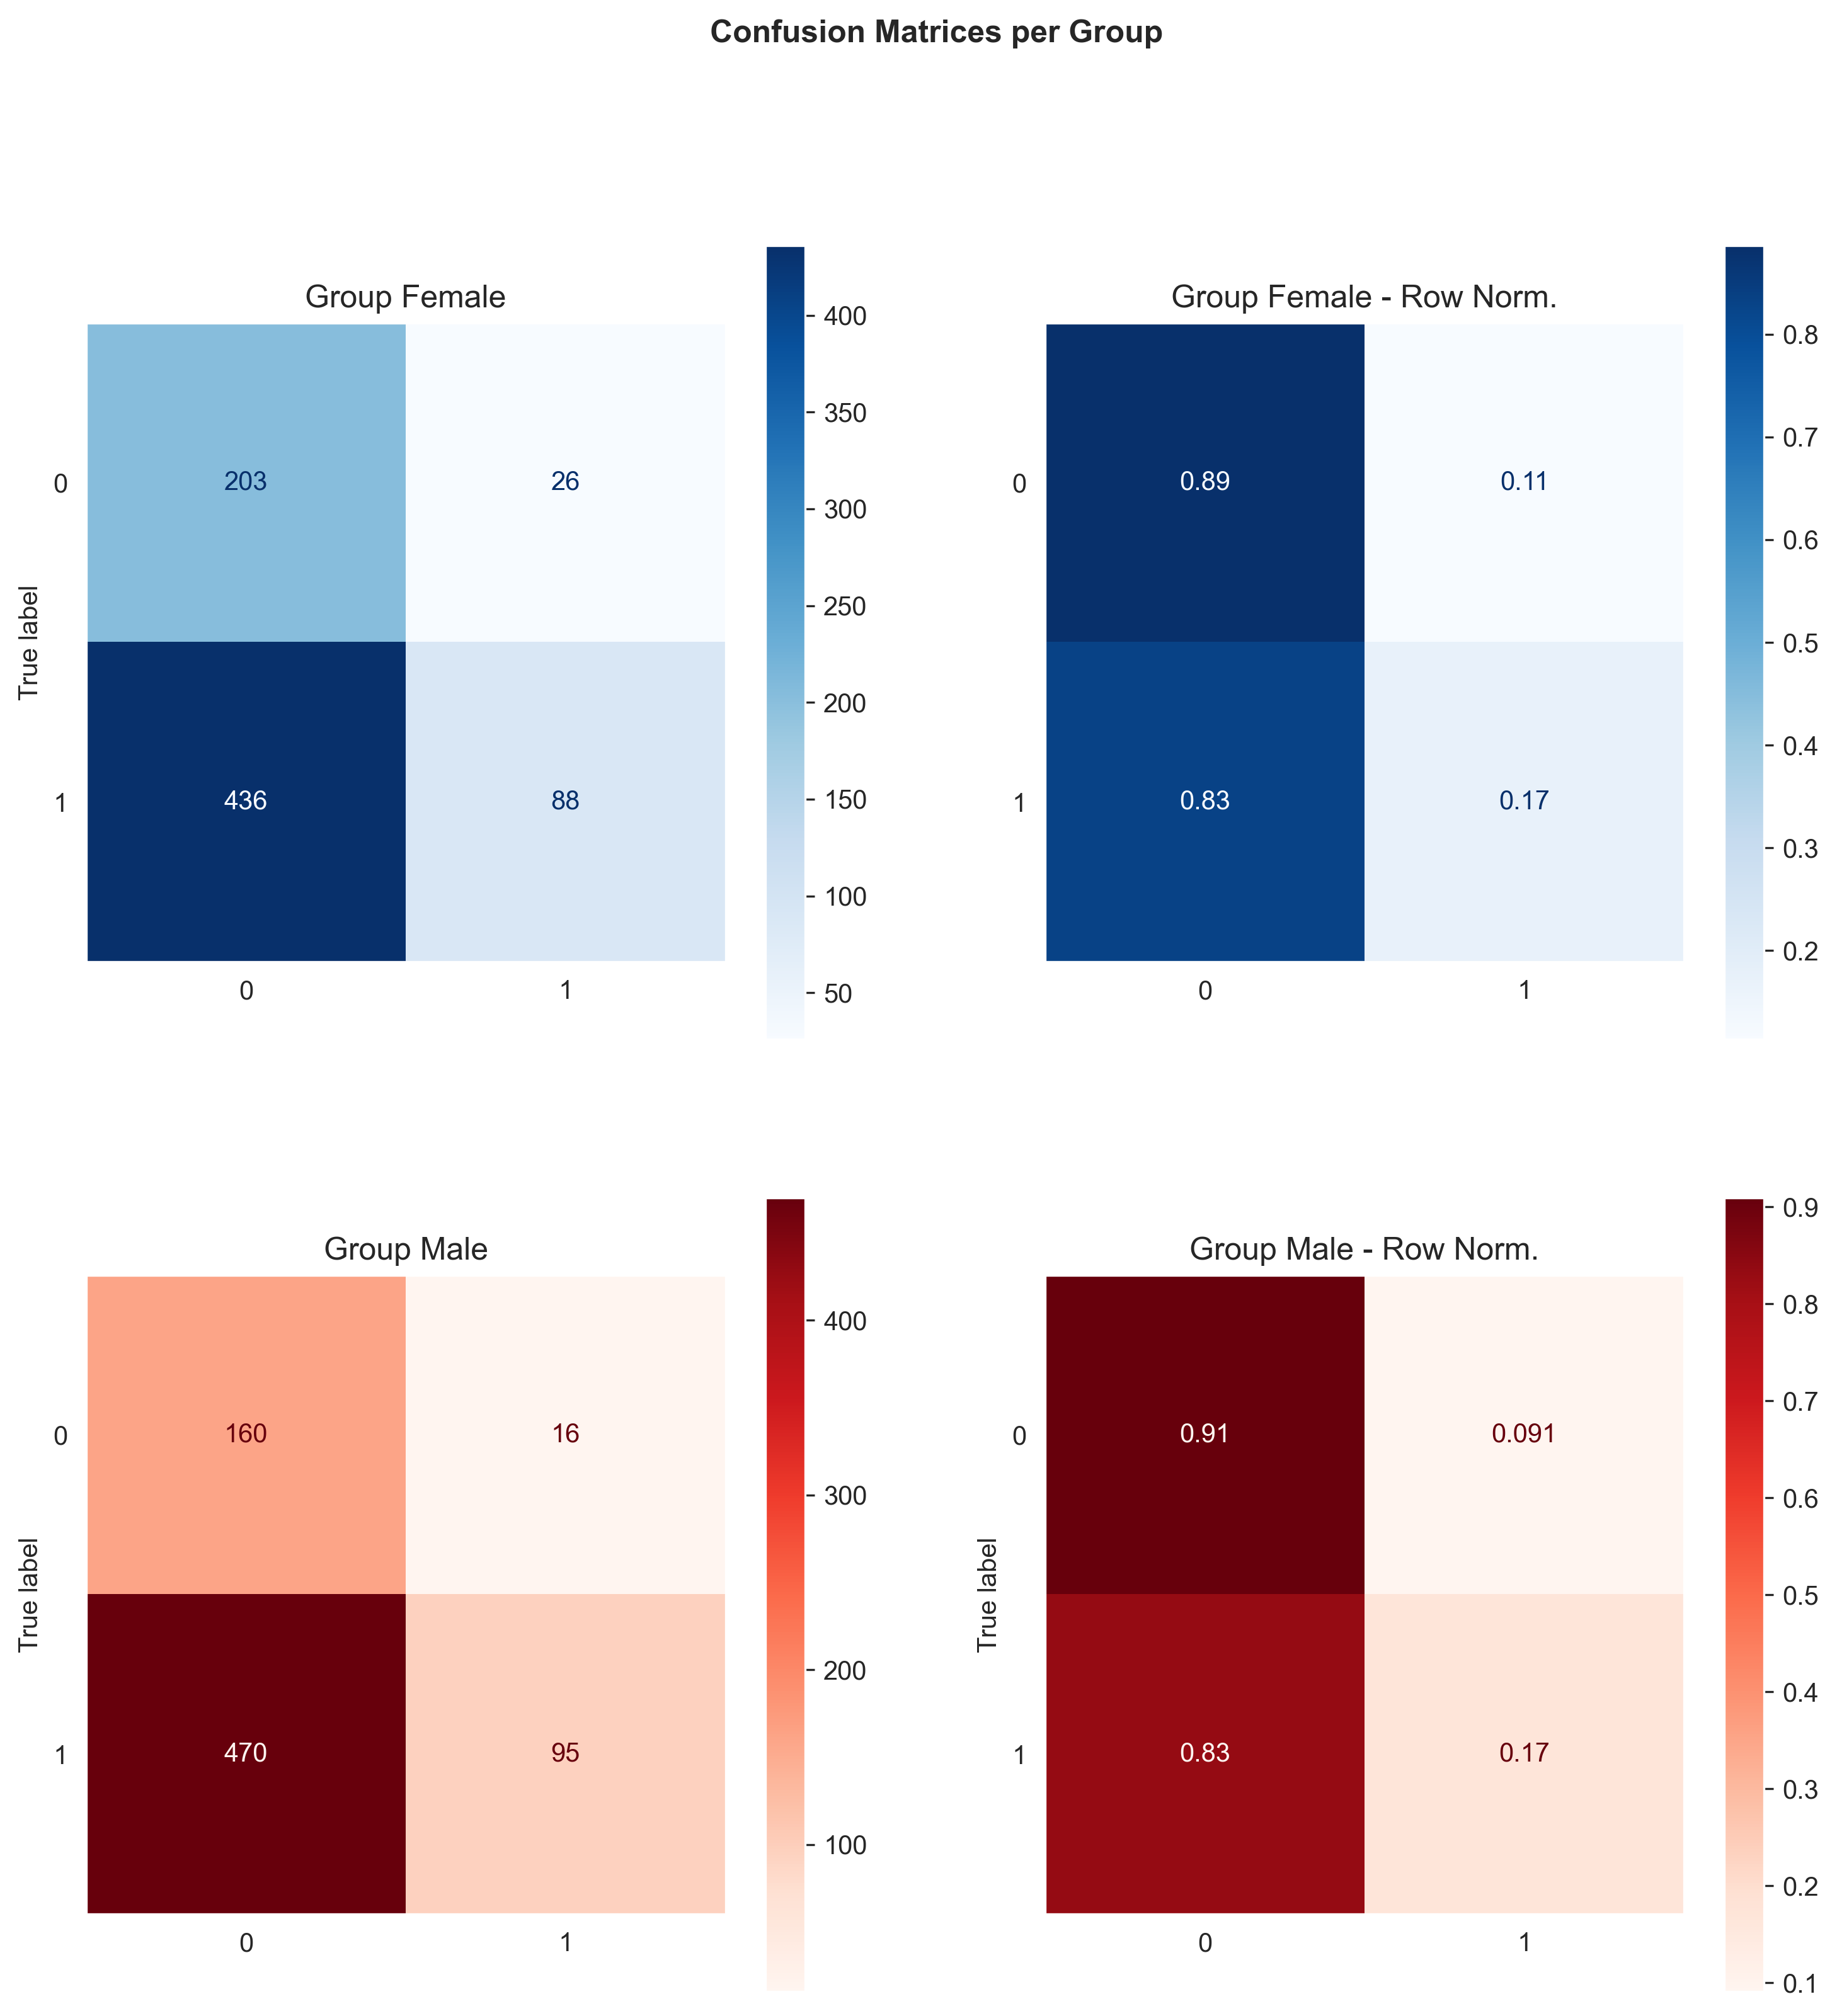

Statistical Parity: False -> P(s=1 | G=Female): 0.151 & P(s=1 | G=Male): 0.150
Equalized Odds: False -> TPR Group Female: 0.168 & FPR Group Female: 0.114 & TPR Group Male: 0.168 & FPR Group Male: 0.091
Equalized Outcomes: False -> P(T=1 | G=Female, S=1): 0.772 & P(T=1 | G=Female, S=0): 0.682 & P(T=1 | G=Male, S=1): 0.856 & P(T=1 | G=Male, S=0): 0.746


In [46]:
fr.fit(y_true = np.argmax(y_test, axis=1), y_pred = y_pred_labels, group = test_metadata["gender"], pred_prob = y_hat, index=test_metadata.index)
fr.compute()

### ROC Curves per group

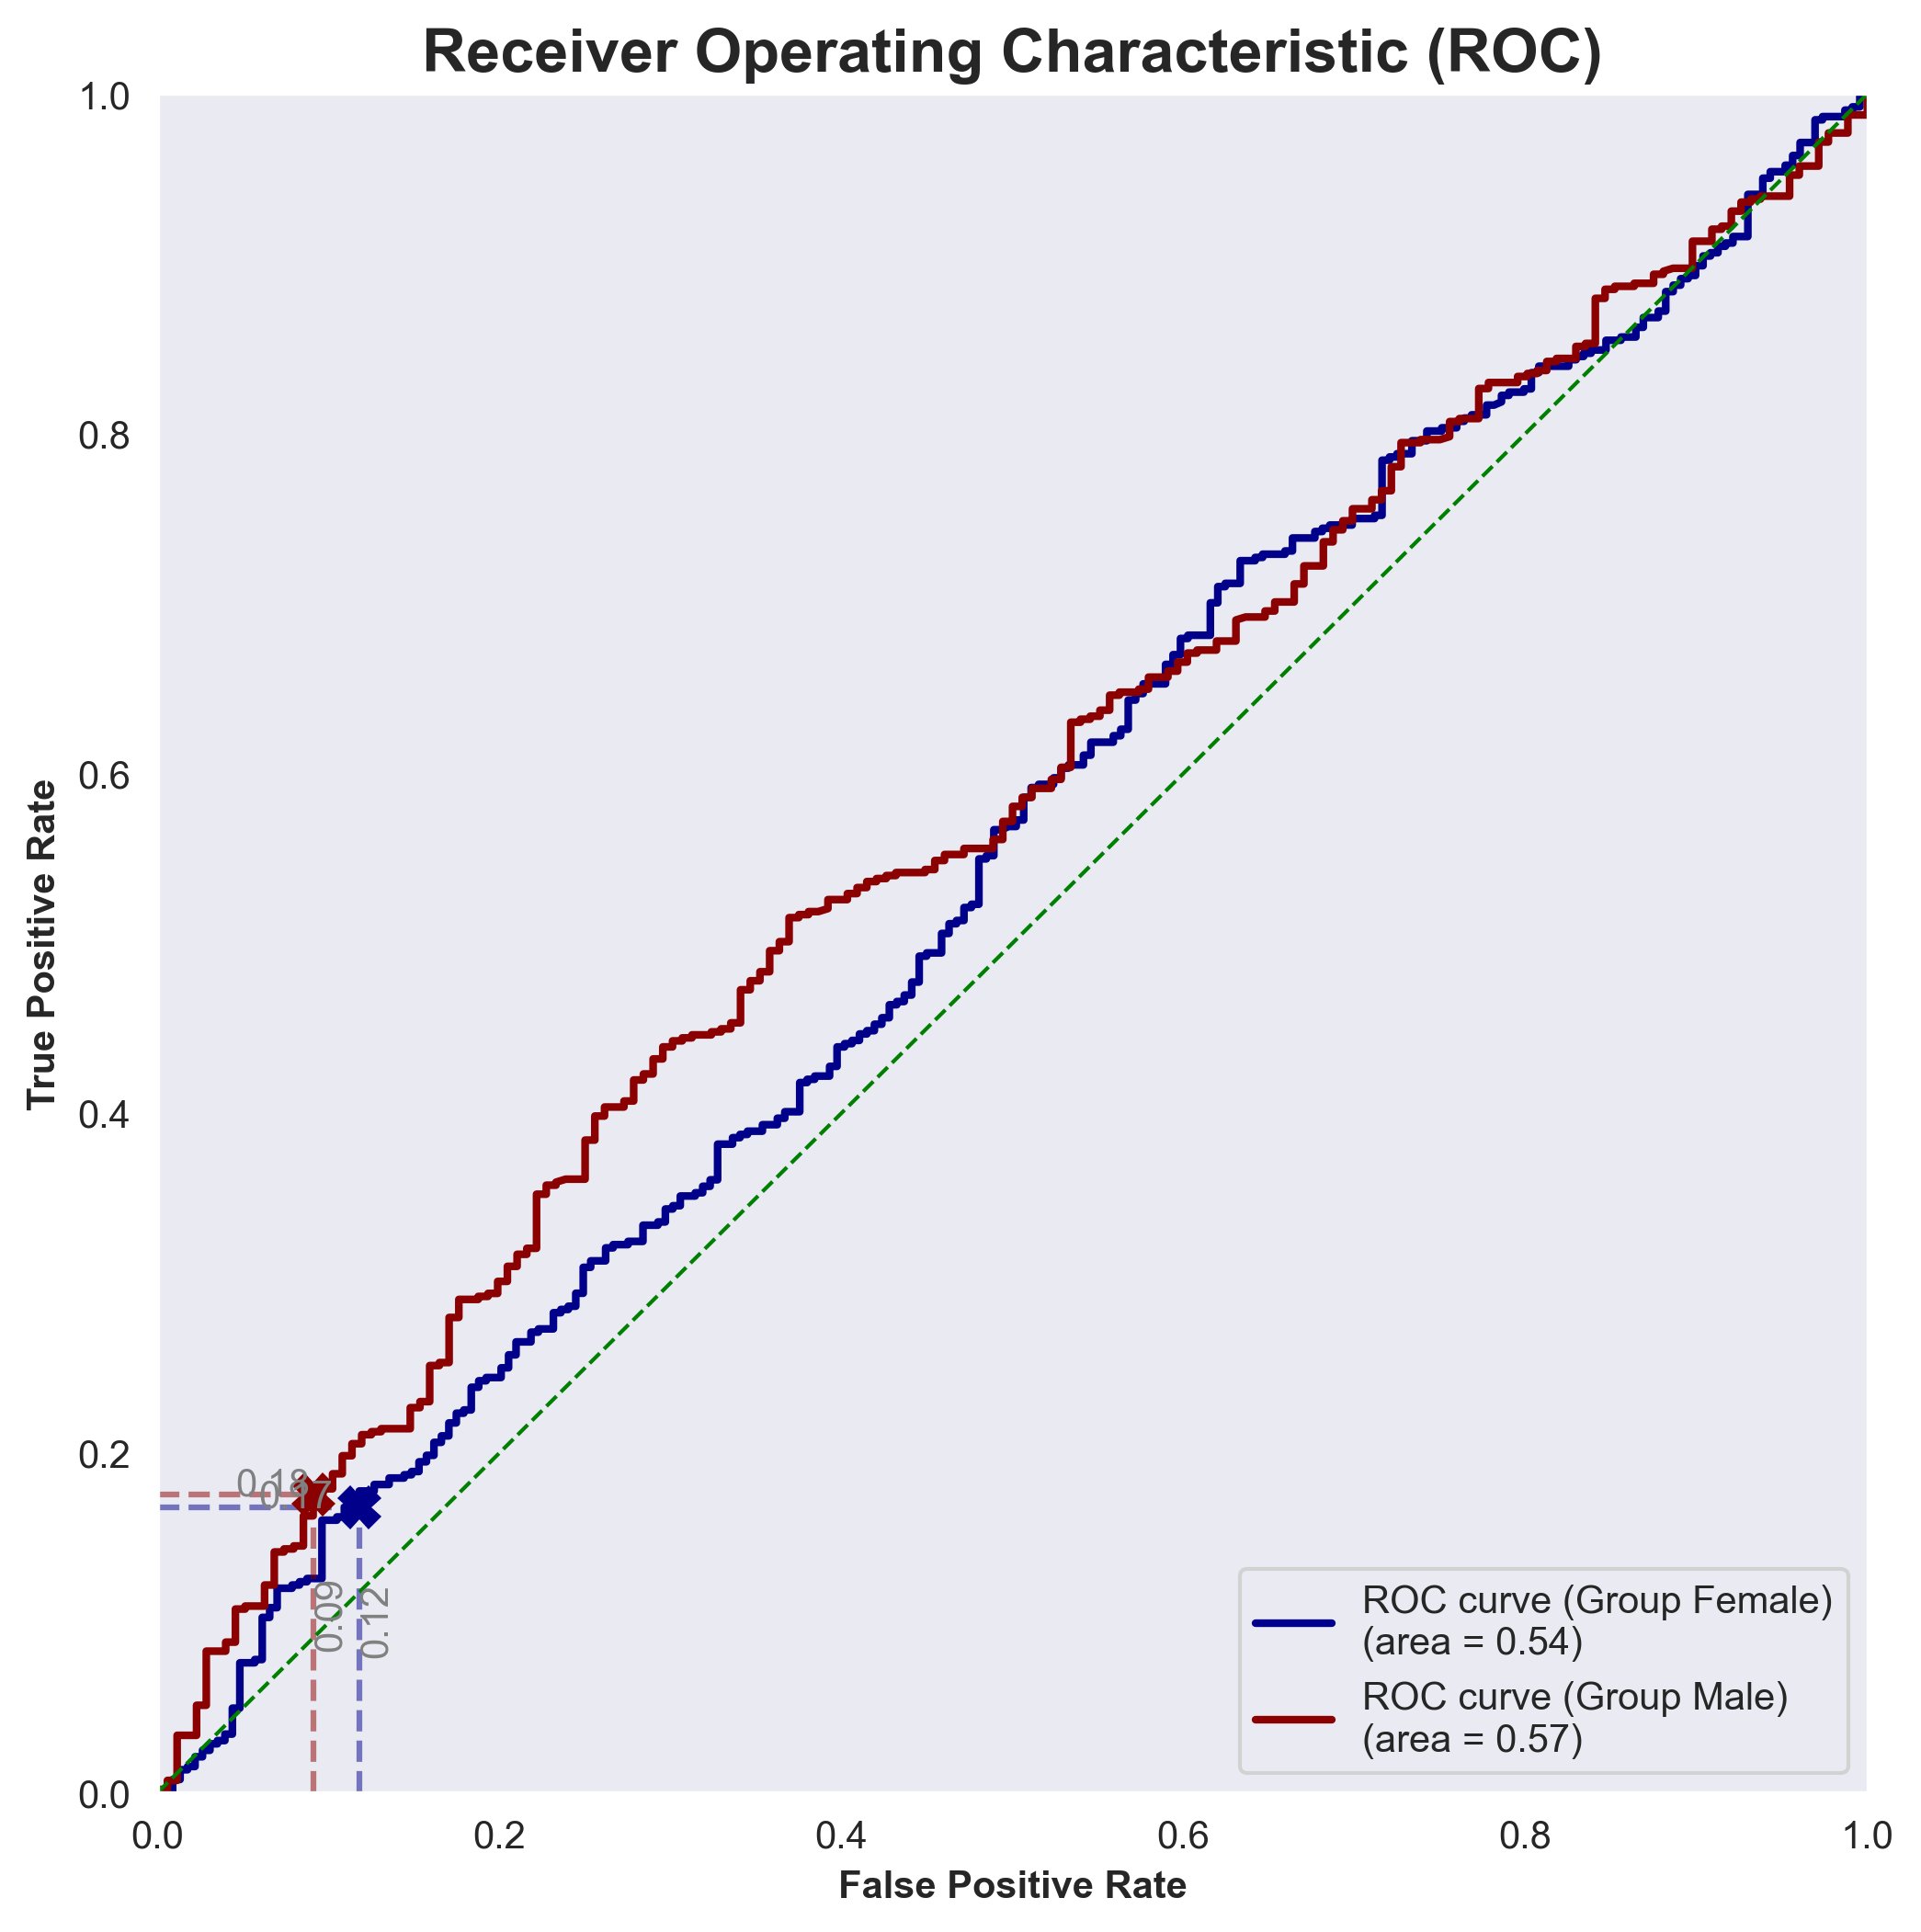

In [47]:
fr.plot_roc_curves(highlight = {"Male": 0.1, "Female": 0.1}, save="gender.png")

## Intersectional Fairness

Intersections (Gender - Skin)

In [48]:
# Create intersections
inter_group = test_metadata[['gender', 'fitspatrick']].agg('-'.join, axis=1)

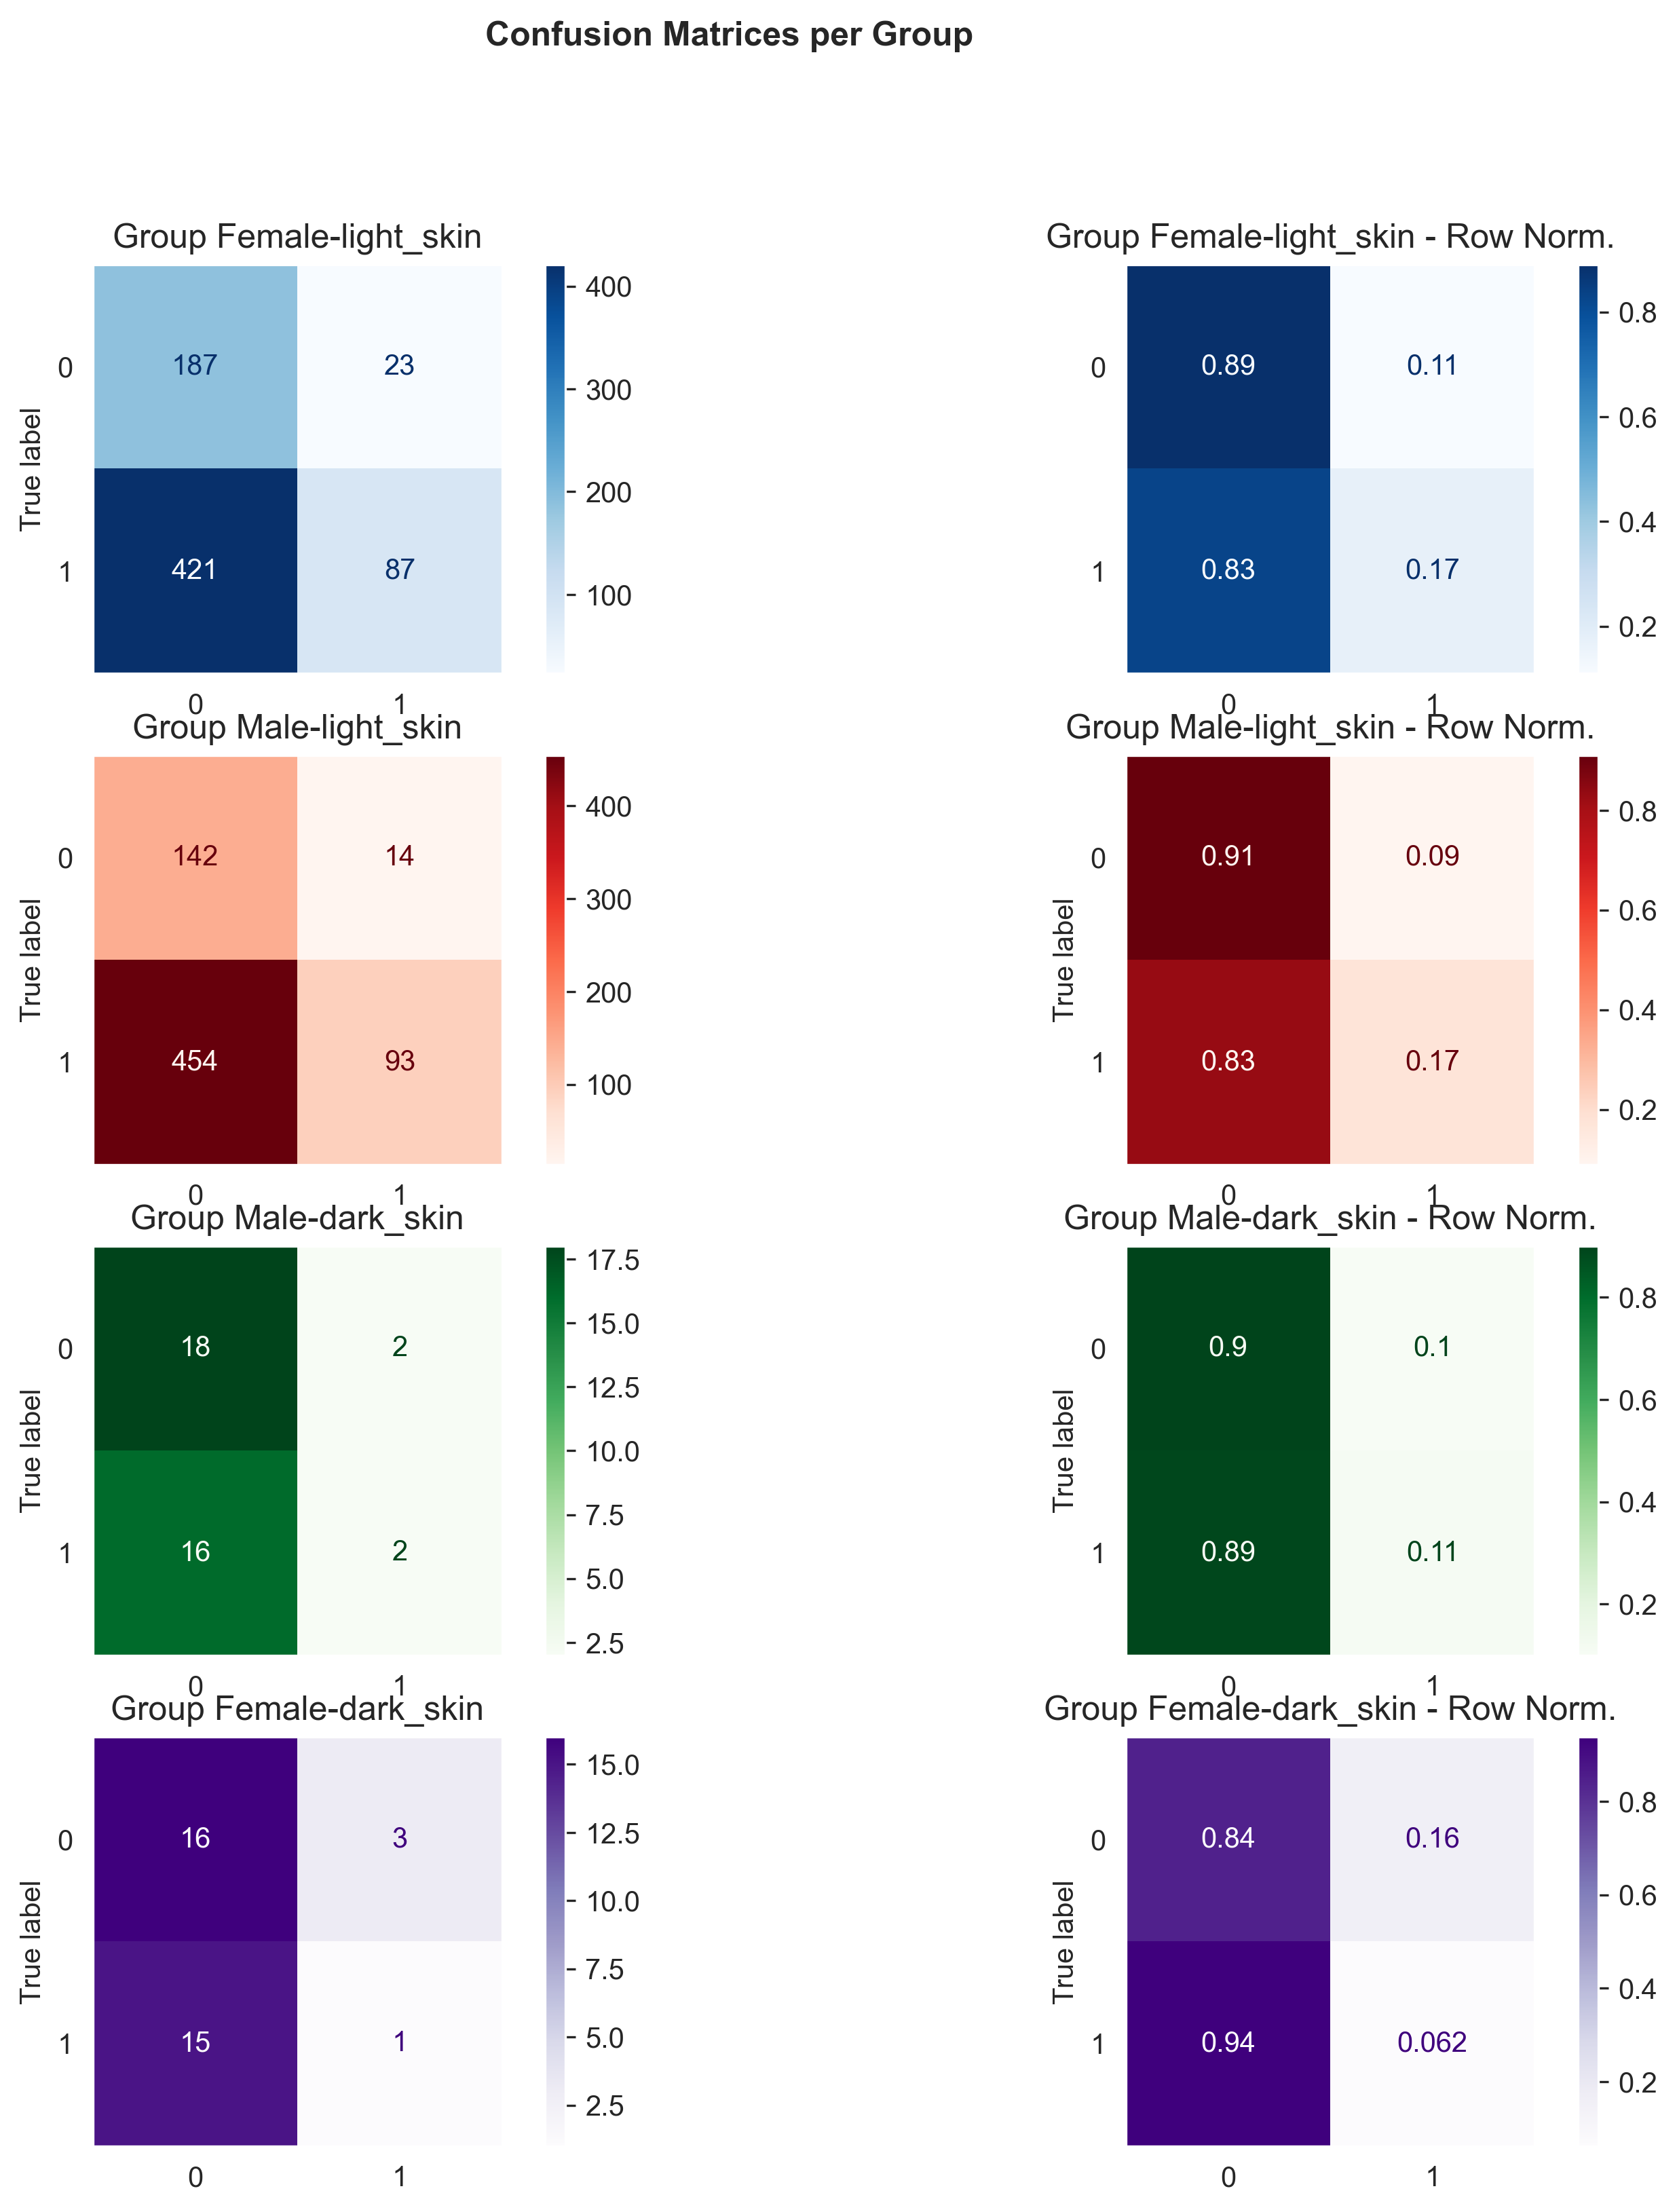

Statistical Parity: False -> P(s=1 | G=Female-light_skin): 0.153 & P(s=1 | G=Male-light_skin): 0.152 & P(s=1 | G=Male-dark_skin): 0.105 & P(s=1 | G=Female-dark_skin): 0.114
Equalized Odds: False -> TPR Group Female-light_skin: 0.171 & FPR Group Female-light_skin: 0.110 & TPR Group Male-light_skin: 0.170 & FPR Group Male-light_skin: 0.090 & TPR Group Male-dark_skin: 0.111 & FPR Group Male-dark_skin: 0.100 & TPR Group Female-dark_skin: 0.062 & FPR Group Female-dark_skin: 0.158
Equalized Outcomes: False -> P(T=1 | G=Female-light_skin, S=1): 0.791 & P(T=1 | G=Female-light_skin, S=0): 0.692 & P(T=1 | G=Male-light_skin, S=1): 0.869 & P(T=1 | G=Male-light_skin, S=0): 0.762 & P(T=1 | G=Male-dark_skin, S=1): 0.500 & P(T=1 | G=Male-dark_skin, S=0): 0.471 & P(T=1 | G=Female-dark_skin, S=1): 0.250 & P(T=1 | G=Female-dark_skin, S=0): 0.484


In [49]:
fr.fit(y_true = np.argmax(y_test, axis=1), y_pred = y_pred_labels, group = inter_group, pred_prob = y_hat, index=test_metadata.index)
fr.compute()

### ROC Curves per group (Gender - Skin)

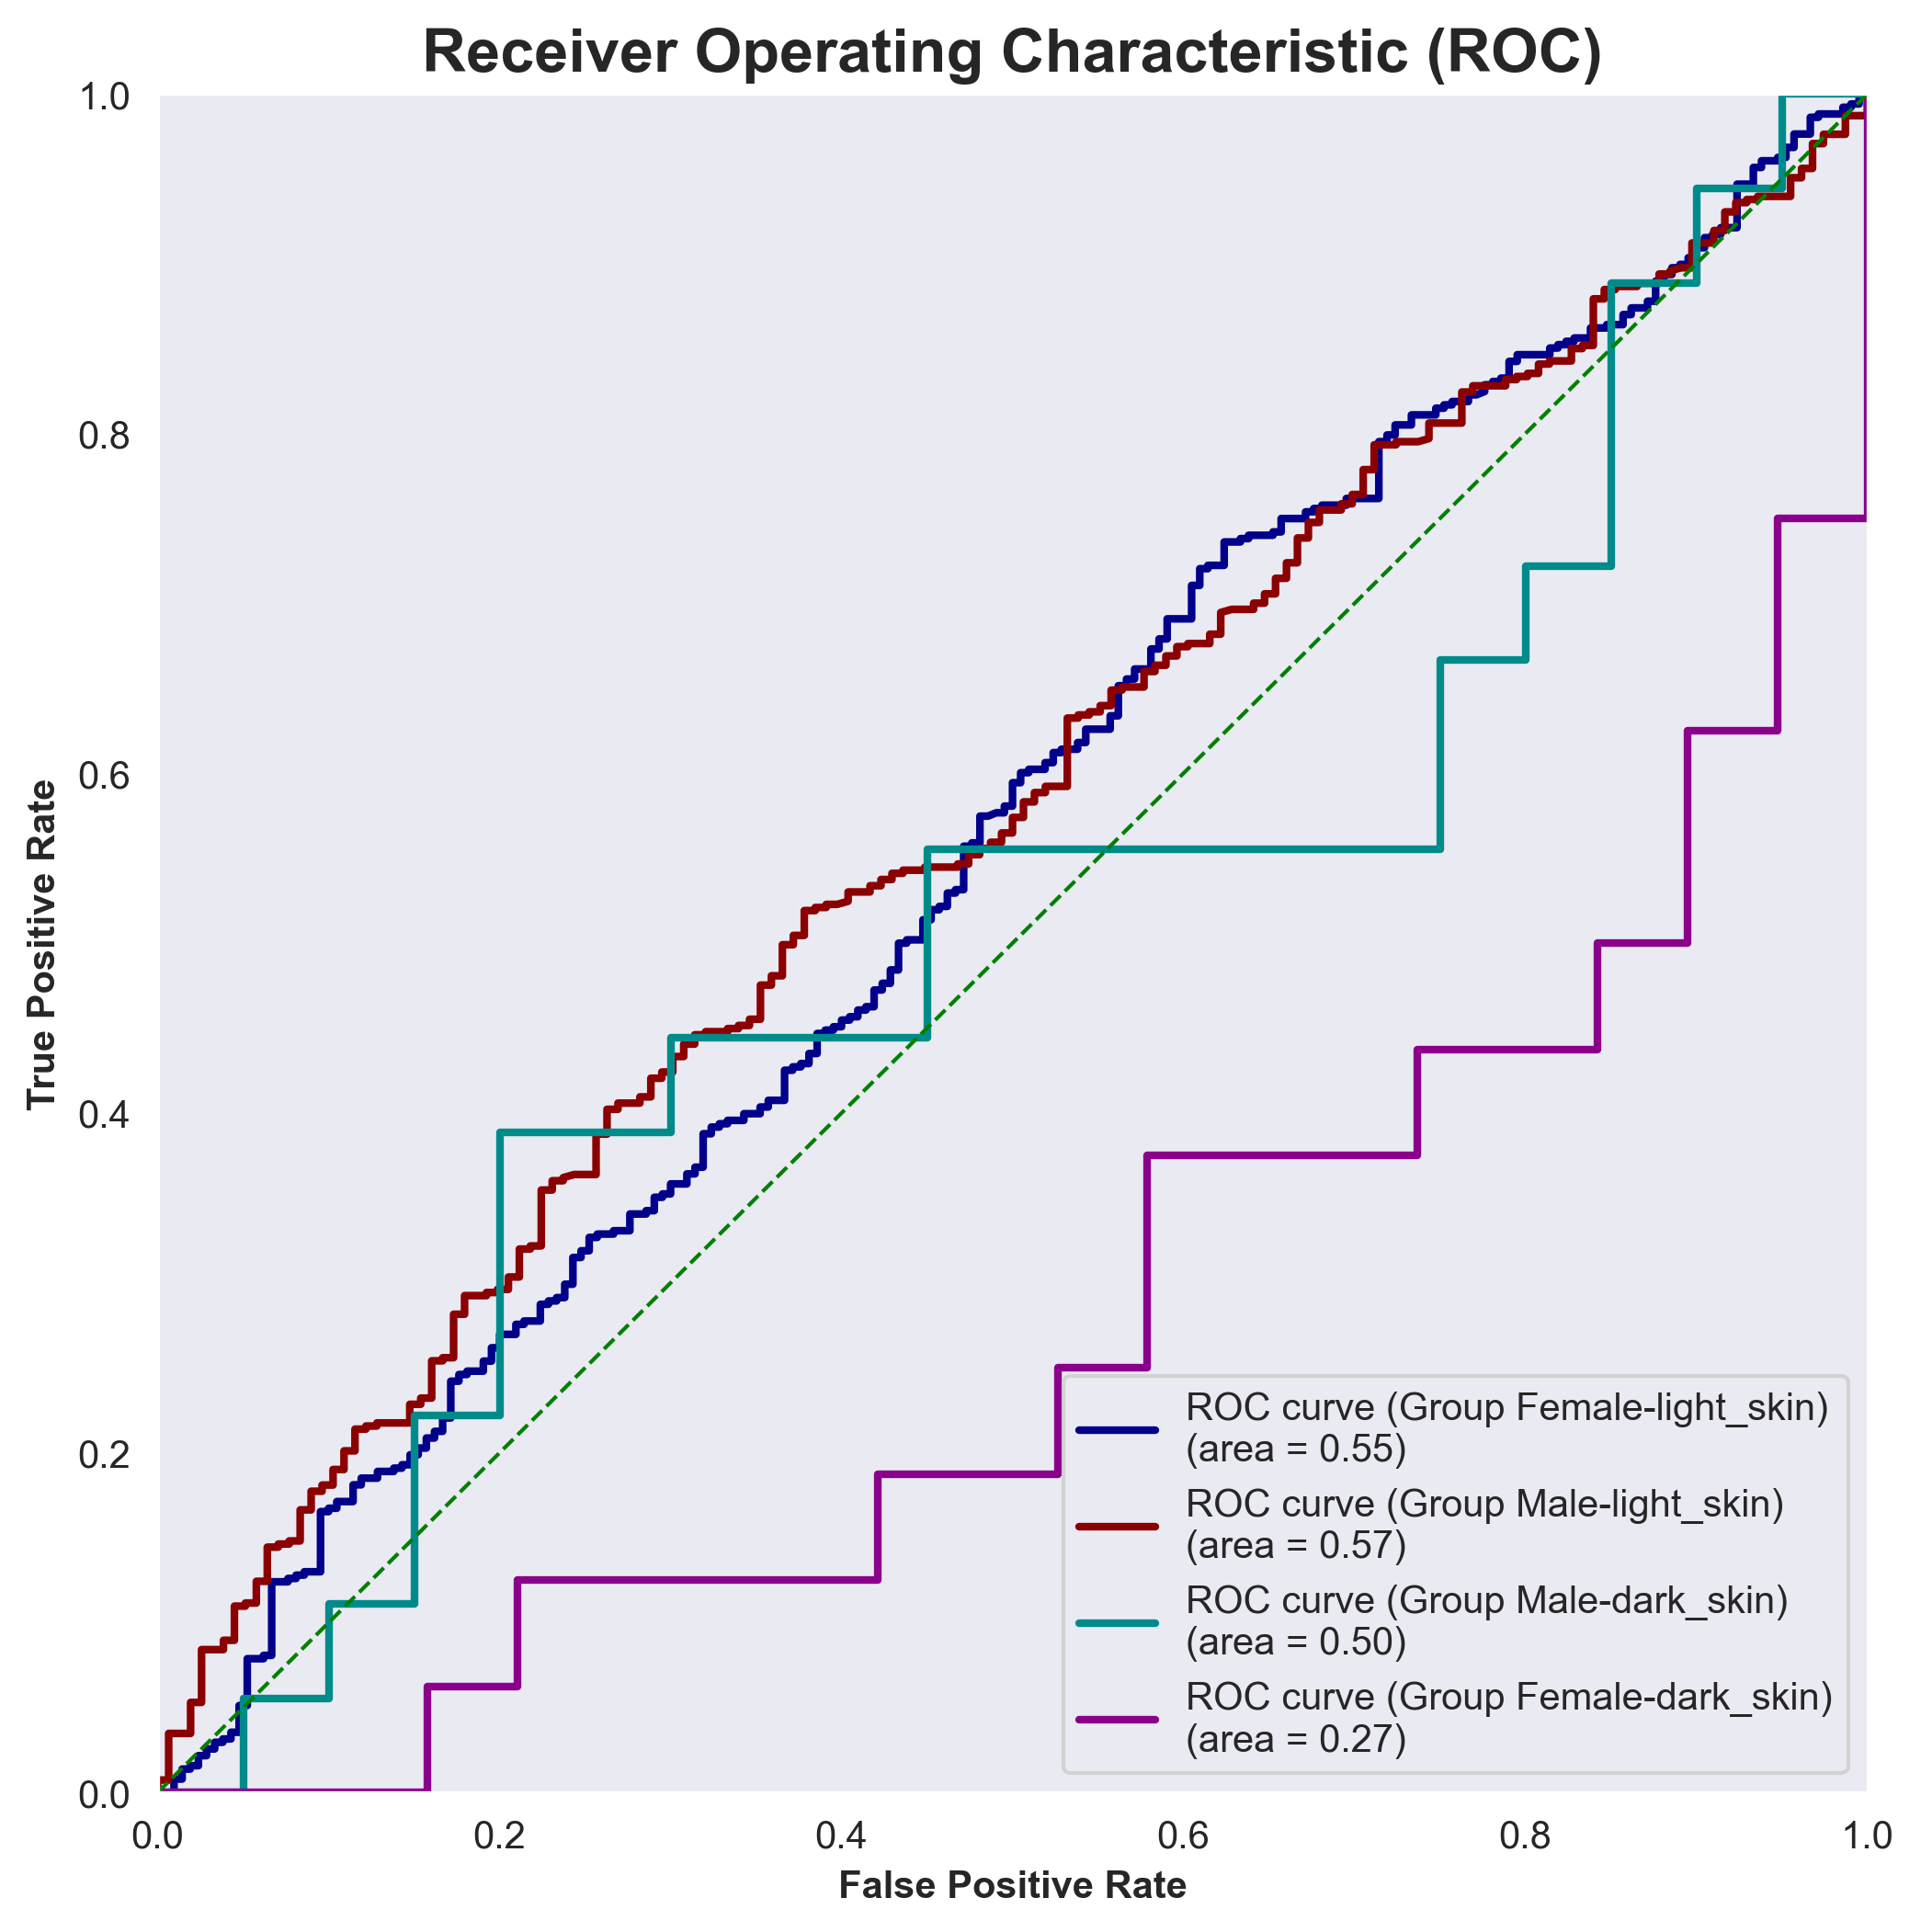

In [50]:
fr.plot_roc_curves(save="intersect.png")